<a href="https://colab.research.google.com/github/MatteoFusconi/Artificial-Intelligence-master/blob/main/Project/EFR_ERC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **_Emotion Discovery and Reasoning its Flip in Conversation_**

**Authors**: Chiara Angileri, Matteo Fusconi, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [1]:
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, get_linear_schedule_with_warmup, AutoTokenizer

from google.colab import drive

In [2]:
def fix_random(seed):
    """Fix all the possible sources of randomness.
        :param seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


## 1. Corpus loading and exploration

### 1.1. Corpus loading

Download the data and split into train (80%), validation (10%) and test (10%).

In [4]:
from_drive = True

if from_drive:
  drive.mount('/content/drive')

  data_folder = Path.cwd() / "drive" / "MyDrive" / "SemEval24"
  dataset_path = data_folder.joinpath("MELD_train_efr.json")
else:
  dataset_path = 'data/MELD_train_efr.json'

Mounted at /content/drive


In [5]:
dataset = pd.read_json(dataset_path)

#Split in train (80%) and test + validation (20%)
train_df, test_val_df = train_test_split(dataset, test_size=0.2, shuffle=False)

#Split validation and test (10% each w.r.t. the original dataset)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, shuffle=False)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
print(f"The train set has {len(train_df)} examples")
print(f"The val set has {len(val_df)}  examples")
print(f"The test set has {len(test_df)} examples")

The train set has 3200 examples
The val set has 400  examples
The test set has 400 examples


In [7]:
train_df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [8]:
# Deal with missing values: trigger = None --> 0
def fillNone(l: list):
  return [x if type(x) == float else 0. for x in l]

train_df["triggers"] = train_df["triggers"].apply(fillNone)
val_df["triggers"] = val_df["triggers"].apply(fillNone)
test_df["triggers"] = test_df["triggers"].apply(fillNone)

In [9]:
# Set unique triggers and emotions
UNIQUE_TRIGGERS = [0.0, 1.0]

UNIQUE_EMOTIONS = set()
for emotions_list in train_df['emotions']:
    UNIQUE_EMOTIONS.update(emotions_list)

UNIQUE_EMOTIONS = sorted(UNIQUE_EMOTIONS)
print(UNIQUE_EMOTIONS)

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


### 1.2. Dataset inspection

In [10]:
def get_support_plots(title, x_label, y_label, support, INDEX, labels = ["Train", "Validation", "Test"]):
  '''
    Plot the support of the classes in the dataset.
  '''
  plt.figure(figsize=(15, 6))
  bar_width = 0.25
  index = range(len(INDEX))
  colors = ["darkcyan", "palegreen", "salmon"]

  for i, t in enumerate(support):
    total_height = sum(support[i])
    normalized_heights = [h / total_height for h in support[i]]
    if i == 0:
        bar = plt.bar(index, normalized_heights, width=bar_width, color=colors[i], label=labels[i])
    else:
        bar = plt.bar([ofs + i * bar_width for ofs in index], normalized_heights, width=bar_width, color=colors[i], label=labels[i])

    for b in bar:
      yval = b.get_height()
      percentage = "{:.1%}".format(yval)
      plt.text(b.get_x() + b.get_width() / 2, yval, percentage, va='bottom', ha='center')

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.xticks([i + bar_width for i in index], INDEX)
  plt.legend()
  plt.grid(axis='y', alpha=0.75)
  plt.show()

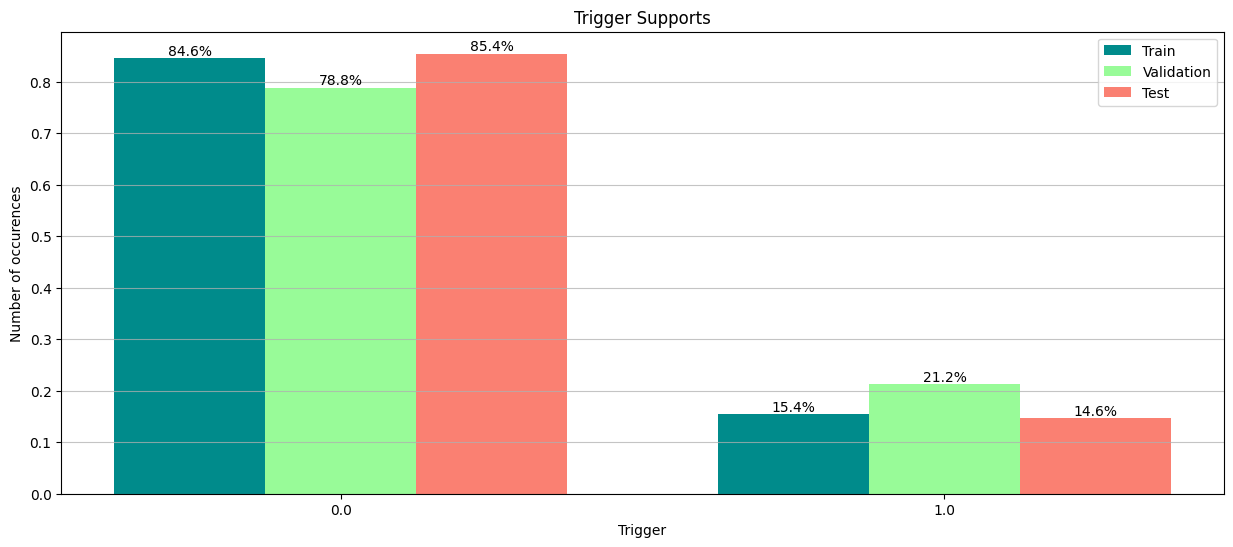

In [11]:
# Triggere support distribution
train_support_triggers = [sum(sublist.count(trigger) for sublist in train_df["triggers"]) for trigger in UNIQUE_TRIGGERS]
val_support_triggers = [sum(sublist.count(trigger) for sublist in val_df["triggers"]) for trigger in UNIQUE_TRIGGERS]
test_support_triggers = [sum(sublist.count(trigger) for sublist in test_df["triggers"]) for trigger in UNIQUE_TRIGGERS]

get_support_plots("Trigger Supports", "Trigger", "Number of occurences", [train_support_triggers, val_support_triggers, test_support_triggers], UNIQUE_TRIGGERS)

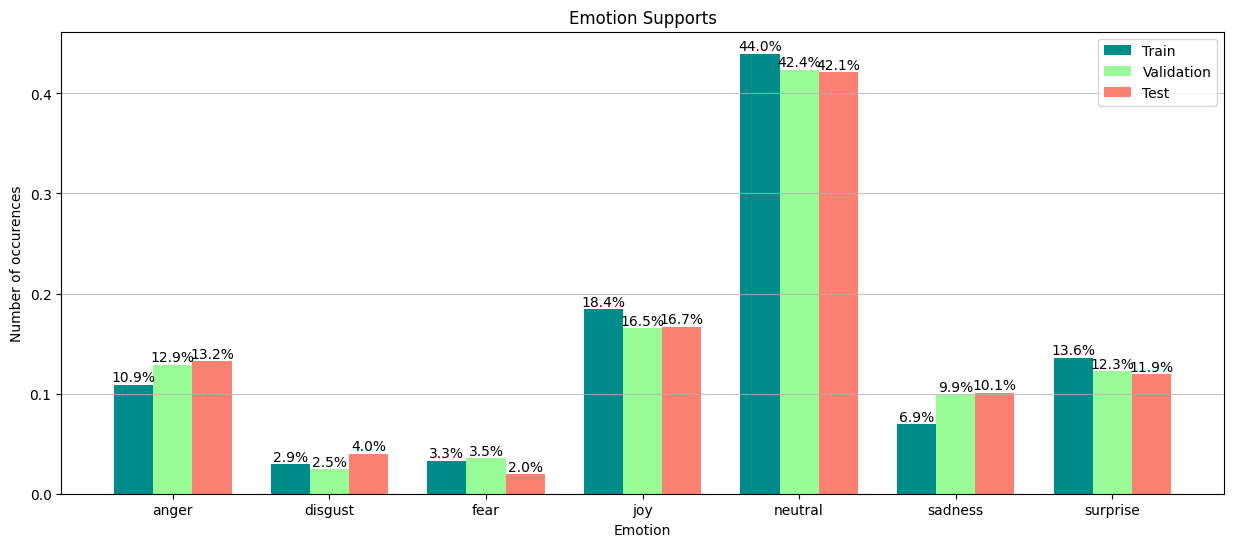

In [12]:
# Emotions support distribution
train_support_emotions = [sum(sublist.count(name) for sublist in train_df["emotions"]) for name in UNIQUE_EMOTIONS]
validation_support_emotions = [sum(sublist.count(name) for sublist in val_df["emotions"]) for name in UNIQUE_EMOTIONS]
test_support_emotions = [sum(sublist.count(name) for sublist in test_df["emotions"]) for name in UNIQUE_EMOTIONS]

get_support_plots("Emotion Supports", "Emotion", "Number of occurences", [train_support_emotions, validation_support_emotions, test_support_emotions], UNIQUE_EMOTIONS)

From the histograms, we can observe a significant class imbalance in the dataset. Specifically, for emotions, the classes 'disgust' and 'fear' are greatly underrepresented, making it very challenging to learn them.

In [13]:
def plot_distributions(data, color, max, x_label = None, y_label = None, title = None, ax = None):
  '''
    Function to plot the distribution of the data.
  '''
  if ax is None:
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=range(1, max + 2), color=color)
    if title is not None:
      plt.title(title)
    if x_label is not None:
      plt.xlabel(x_label)
    if y_label is not None:
      plt.ylabel(y_label)
    plt.grid(axis='y', alpha=0.75)
    plt.xticks(np.arange(1.5, max + 1.5), labels= np.arange(1, max + 1))
    plt.show()
  else:
    ax.hist(data, bins=range(1, max + 2), color=color)
    if title is not None:
      ax.set_title(title)
    if x_label is not None:
      ax.xlabel(x_label)
    if y_label is not None:
      ax.ylabel(y_label)
    ax.grid(axis='y', alpha=0.75)
    ax.set_xticks(np.arange(1.5, max + 1.5))
    ax.set_xticklabels(np.arange(1, max + 1))

In [14]:
def get_episode_plot(ax, df, color, title):
    '''
        Function to plot the distribution and the statistics of the length of the episodes.
    '''
    episode_lengths = df['utterances'].apply(len)
    max_length = episode_lengths.max()
    plot_distributions(episode_lengths, color, max_length, ax = ax, title = title)

def get_speakers_plot(ax, df, color, title):
    '''
        Function to plot the distribution and the statistics of the unique number of speakers per episode.
    '''
    unique_speakers_per_episode = df['speakers'].apply(lambda x: len(set(x)))
    max_value = unique_speakers_per_episode.max()
    plot_distributions(unique_speakers_per_episode, color, max_value, ax = ax, title = title)

def get_triggers_plot(ax, df, color, title):
    '''
        Function to plot the distribution and the statistics of the number of triggers per episode.
    '''
    n_triggers_per_episode = df['triggers'].apply(lambda x: int(sum(x)))
    max_value = n_triggers_per_episode.max()
    plot_distributions(n_triggers_per_episode, color, max_value, ax = ax, title = title)

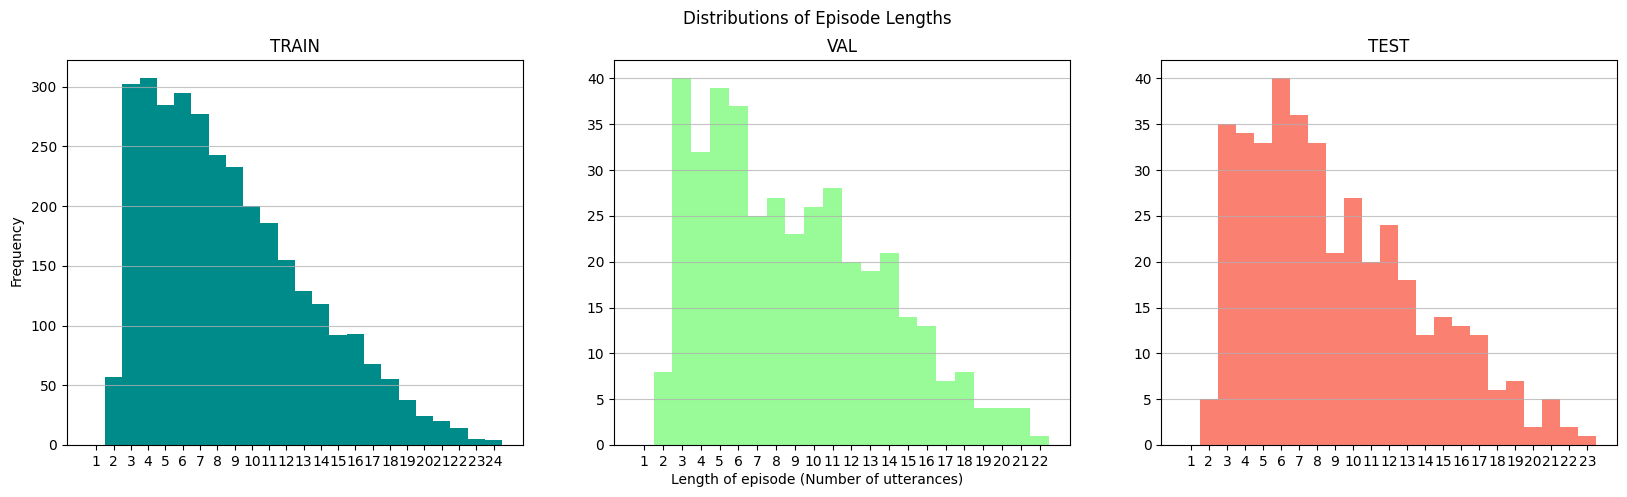

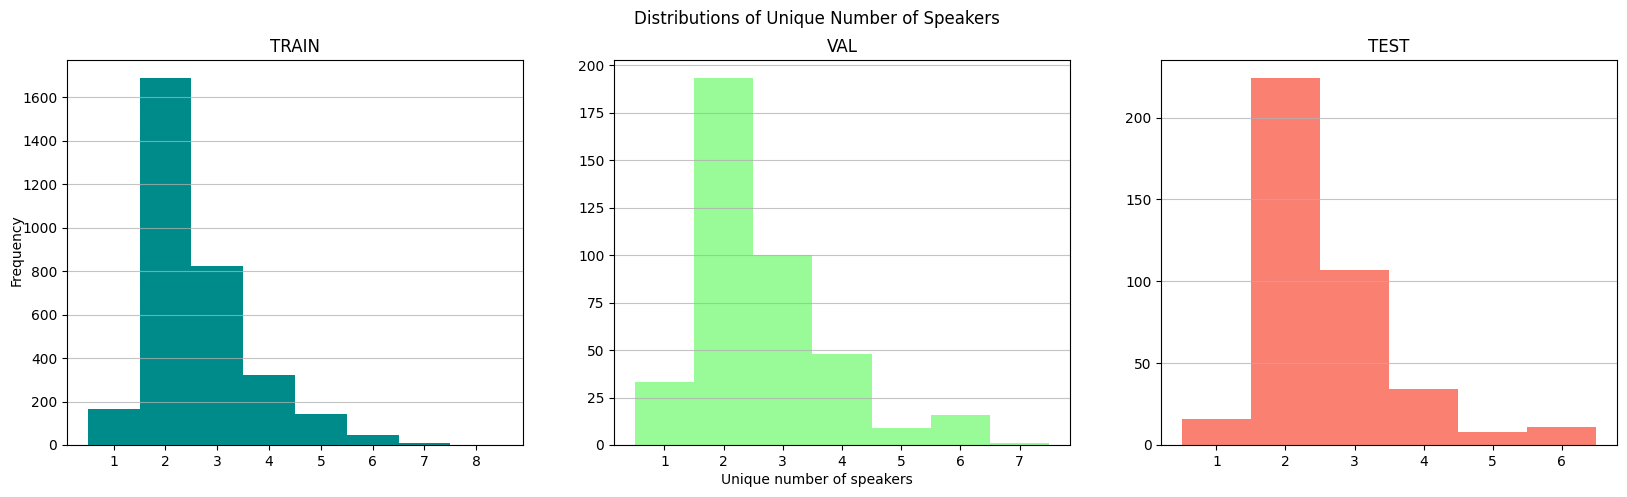

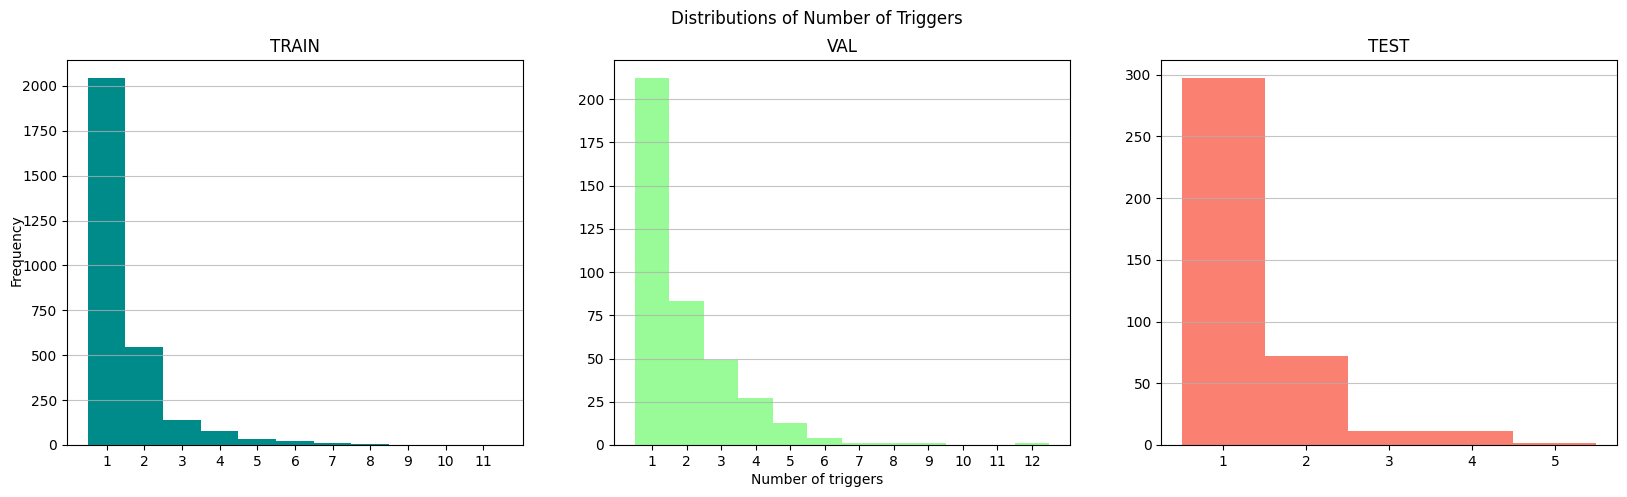

In [15]:
# Create subplots for each split (TRAIN, VAL, TEST)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distributions of Episode Lengths')
get_episode_plot(axes[0], train_df, color="darkcyan", title="TRAIN")
get_episode_plot(axes[1], val_df, color="palegreen", title="VAL")
get_episode_plot(axes[2], test_df, color="salmon", title="TEST")
fig.text(0.1, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Length of episode (Number of utterances)', ha='center', va='center');

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distributions of Unique Number of Speakers')
get_speakers_plot(axes[0], train_df, color="darkcyan", title="TRAIN")
get_speakers_plot(axes[1], val_df, color="palegreen", title="VAL")
get_speakers_plot(axes[2], test_df, color="salmon", title="TEST")
fig.text(0.1, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Unique number of speakers', ha='center', va='center');

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distributions of Number of Triggers')
get_triggers_plot(axes[0], train_df, color="darkcyan", title="TRAIN")
get_triggers_plot(axes[1], val_df, color="palegreen", title="VAL")
get_triggers_plot(axes[2], test_df, color="salmon", title="TEST")
fig.text(0.1, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Number of triggers', ha='center', va='center');

In [16]:
# Maximum length of a sentence in dialogues
lenghts = [len(u.split()) for s in train_df["utterances"].values for u in s]
MAX_LEN_SENTENCE = max(lenghts)
print("Maximum length of a sentence in a dialogue: ", MAX_LEN_SENTENCE)

Maximum length of a sentence in a dialogue:  69


## 2. Data PreProcessing

Step done in preprocessing:
- **Onehot** encoding of emotions
- Track dialogues length

In [17]:
def apply_to_list(l, f):
  '''Apply function f to each element of list l.'''
  return [f(x) for x in l]

In [18]:
# Convert emotions to one-hot encoding
emotions2onehot = {emotion: np.eye(len(UNIQUE_EMOTIONS))[i] for i, emotion in enumerate(UNIQUE_EMOTIONS)}

train_df['emotions'] = train_df['emotions'].apply(lambda x: apply_to_list(x, lambda y: emotions2onehot[y]))
val_df['emotions'] = val_df['emotions'].apply(lambda x: apply_to_list(x, lambda y: emotions2onehot[y]))
test_df['emotions'] = test_df['emotions'].apply(lambda x: apply_to_list(x, lambda y: emotions2onehot[y]))

In [19]:
# Add a column with the number of utterances in the dialogue
train_df['n_utterances'] = train_df['utterances'].apply(len)
val_df['n_utterances'] = val_df['utterances'].apply(len)
test_df['n_utterances'] = test_df['utterances'].apply(len)

In [20]:
train_df.head()

,episode,speakers,emotions,utterances,triggers,n_utterances
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0....",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]",5
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0....",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",7
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0....",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0....",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0....",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]",4


## 3. Dataloader creation

In order to create the DataLoader we have done the following steps:
- order the dataframes by len, from smaller to bigger dialogues;
- transform each sentence in the dialogue as **_speaker_ : _utterance_**, and tokenize all the dialogue through the _AutoTokenizer_;
- define the *collate_fn* function in order to have batches where dialogues have a different number of utterances;
- create the DataLoader for train, validation and test splits specifying the batch size and the model card to use.

In [21]:
def order_df_by_len(ds):
  '''
    Function to order the dataframe by the length of the dialogue.
  '''
  ds['length'] = ds['utterances'].apply(len)
  return ds.sort_values(by='length').reset_index(drop=True).iloc[:,:-1]

train_df = order_df_by_len(train_df)
test_df = order_df_by_len(test_df)
val_df = order_df_by_len(val_df)

In [22]:
class TokenizerDataset(Dataset):
  '''
    Class to tokenize the dataset.
  '''
  def __init__(self, data, tokenizer, max_len, use_speakers):
    self.tokenizer = tokenizer
    self.data = data
    self.max_len = max_len
    self.use_speakers = use_speakers

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    if self.use_speakers:
      # speaker : utterance
      flatten_dialogue = [f"{self.data.speakers[index][i]} : {self.data.utterances[index][i]} " for i in range(len(self.data.utterances[index]))]
    else:
      flatten_dialogue = self.data.utterances[index]

    tokenized_sentences = self.tokenizer(flatten_dialogue, add_special_tokens = True, max_length = self.max_len, truncation = True, padding = 'max_length')

    utts_ids = tokenized_sentences['input_ids']
    utts_mask = tokenized_sentences['attention_mask']

    return {
            "dialogue_ids": torch.tensor(utts_ids, dtype = torch.long),
            "dialogue_mask": torch.tensor(utts_mask, dtype=torch.long),

            "emotions": torch.tensor(np.array(self.data.emotions[index]), dtype = torch.float32),
            "triggers": torch.tensor(np.array(self.data.triggers[index]), dtype = torch.float32),

            "n_utterances": torch.tensor(self.data.n_utterances[index], dtype = torch.long)
    }

def collate_fn(batch):
    '''
      Function to pad the batch.
    '''
    processed_batch = {
        "dialogue_ids": pad_sequence([item["dialogue_ids"] for item in batch], batch_first=True),
        "dialogue_mask": pad_sequence([item["dialogue_mask"] for item in batch], batch_first=True),

        "triggers": pad_sequence([item["triggers"] for item in batch], batch_first=True),
        "emotions": pad_sequence([item["emotions"] for item in batch], batch_first=True),

        "n_utterances": torch.tensor([item["n_utterances"] for item in batch], dtype = torch.long)
    }

    return processed_batch

In [23]:
def get_dataloaders(train_df, val_df, test_df, model_card, max_len, batch_size, collate_fn, use_speakers):
  '''
    Function to create the dataloaders.
    :param train_df: the training dataframe.
    :param val_df: the validation dataframe.
    :param test_df: the test dataframe.
    :param model_card: the model card to use.
    :param max_len: the maximum length of the sentences.
    :param batch_size: the batch size.
    :param collate_fn: the function to pad the batch.
    :param use_speakers: whether to use speakers or not.

    :return: the dataloaders.
  '''
  # Tokenize the dataset
  tokenizer = AutoTokenizer.from_pretrained(model_card)

  train_ds = TokenizerDataset(train_df, tokenizer, max_len = max_len, use_speakers = use_speakers)
  val_ds = TokenizerDataset(val_df, tokenizer, max_len = max_len, use_speakers = use_speakers)
  test_ds = TokenizerDataset(test_df, tokenizer, max_len = max_len, use_speakers = use_speakers)

  # Create the dataloaders
  train_dl = DataLoader(train_ds, batch_size = batch_size, collate_fn = collate_fn)
  val_dl = DataLoader(val_ds, batch_size = batch_size, collate_fn = collate_fn)
  test_dl = DataLoader(test_ds, batch_size = batch_size, collate_fn = collate_fn)

  return train_dl, val_dl, test_dl

In [24]:
# Check the shape of the batch
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_dl, _, _ = get_dataloaders(train_df, val_df, test_df, model_card = "bert-base-uncased", max_len = MAX_LEN_SENTENCE, batch_size = 4, collate_fn = collate_fn, use_speakers = False)

it = iter(train_dl)
batch_train = next(it)
for k, v in batch_train.items():
  print(k, ": ", v.shape)

# Check the first example
example = batch_train['dialogue_ids'][0][0]
print(tokenizer.decode(example))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

dialogue_ids :  torch.Size([4, 2, 69])
dialogue_mask :  torch.Size([4, 2, 69])
triggers :  torch.Size([4, 2])
emotions :  torch.Size([4, 2, 7])
n_utterances :  torch.Size([4])
[CLS] no real -, honey, really it's fine, just g - go with susan. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## 4. Models definition

### 4.1. Dummy classifiers

We defined two types of Dummy classifiers for each target wh need to predict:
- Dummy classifier with _uniform_ strategy to predict the emotions
- Dummy classifier with _majority_ strategy to predict the emotions
- Dummy classifier with _uniform_ strategy to predict the triggers
- Dummy classifier with _majority_ strategy to predict the triggers

In [25]:
def onehot2col(df, col_name, flatten = False):
  '''
    Function to convert one-hot encoding to column.
      :param df: the dataframe.
      :param col_name: the name of the column to convert.
      :param flatten: if True, the column is flattened.
      :return: the converted column.
  '''
  if flatten:
      return list(chain.from_iterable(df[col_name].apply(lambda x: apply_to_list(x, lambda y: np.argmax(y)))))
  else:
      return df[col_name].apply(lambda x: apply_to_list(x, lambda y: np.argmax(y)))

In [26]:
# Create the dummy classifiers
uniform_emotions = DummyClassifier(strategy = "uniform")
majority_emotions = DummyClassifier(strategy = "prior")
uniform_triggers = DummyClassifier(strategy = "uniform")
majority_triggers = DummyClassifier(strategy = "prior")

### 4.2. BERT base model

Regarding this model, we used a pretrained Bert model for embedding the dialogues, and then we defined two classification heads: one for each target.
- **_Emotion head_**: two dense layers and a dropout layer.
- **_Trigger head_**: a bidirectional LSTM layer to take into account the context of the dialogue, and a dense layer.

In [27]:
class EmotionHead(nn.Module):
    '''
        This class is used to create the emotion head of the model.
    '''
    def __init__(self, embedding_dim, hidden_size, emotion_dim = 7):
        super().__init__()
        self.emotion_dim = emotion_dim
        self.embedding_dim = embedding_dim

        self.emo1dense = nn.Linear(self.embedding_dim, hidden_size)
        self.emo2dense = nn.Linear(hidden_size, self.emotion_dim)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, embedded_dialogues):
        emo = self.emo1dense(embedded_dialogues)
        emo = self.relu(emo)
        emo = self.dropout(emo)
        emo = self.emo2dense(emo)

        return emo

class TriggerHead(nn.Module):
    '''
        This class is used to create the trigger head of the model.
    '''
    def __init__(self, embedding_dim, hidden_size, trigger_dim = 1):
        super().__init__()
        self.trigger_dim = trigger_dim
        self.embedding_dim = embedding_dim

        self.triLSTM = nn.LSTM(self.embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.tridense = nn.Linear(hidden_size*2, self.trigger_dim)

    def forward(self, embedded_dialogues):
        tri, _ = self.triLSTM(embedded_dialogues)
        tri = self.tridense(tri)

        return tri

In [28]:
class BertModel(nn.Module):
  '''
    This class is used to create the model.
  '''
  def __init__(self, hidden_size, model_card, freeze = True):
    super().__init__()
    #self.bert = BertModel.from_pretrained(model_card, return_dict = False)
    self.bert = AutoModel.from_pretrained(model_card, return_dict = False)
    self.embedding_dim = self.bert.config.hidden_size

    # Freeze parameters
    if freeze:
      for param in self.bert.parameters():
          param.requires_grad = False

    self.emo_head = EmotionHead(self.embedding_dim, hidden_size)
    self.tri_head = TriggerHead(self.embedding_dim, hidden_size)

  def forward(self, ids, mask):

    batch_size, dialog_len, utterance_len = ids.shape

    embedded_dialogues = torch.cat([self.bert(ids[d], mask[d])[1] for d in range(batch_size)])
    embedded_dialogues = embedded_dialogues.reshape(batch_size, dialog_len, self.embedding_dim)

    emo = self.emo_head(embedded_dialogues)
    tri = self.tri_head(embedded_dialogues)

    return emo, tri

## 5. Metrics

The model is evaluated on two metrics:
- **_Sequence F1_**: we compute the f1-score for each dialogue and then we report the average score.
- **_Unrolled Sequence F1_**: we flatten all utterances and then compute the f1-score.

Both metrics are computed for emotions and triggers labels.

In [29]:
def model_evaluation(y_true_emo, y_pred_emo, y_true_tri, y_pred_tri):
  '''
      Function to evaluate the model.
        :param y_true_emo: the true emotions.
        :param y_pred_emo: the predicted emotions.
        :param y_true_tri: the true triggers.
        :param y_pred_tri: the predicted triggers.
        :return: the evaluation scores.
  '''

  # Emotions
  f1_unrolled_emo = f1_score(np.concatenate(y_true_emo), np.concatenate(y_pred_emo), average='macro')

  f1_emo_per_dialogue = [f1_score(true, pred, average='micro') for true, pred in zip(y_true_emo, y_pred_emo)]
  f1_seq_emo = np.mean(f1_emo_per_dialogue)

  # Triggers
  f1_unrolled_tri = f1_score(np.concatenate(y_true_tri), np.concatenate(y_pred_tri), average='binary', zero_division = 0)

  f1_tri_per_dialogue = [f1_score(true, pred, average='binary', zero_division = 0) for true, pred in zip(y_true_tri, y_pred_tri)]
  f1_seq_tri = np.mean(f1_tri_per_dialogue)

  return f1_seq_emo, f1_unrolled_emo, f1_seq_tri, f1_unrolled_tri

## 6. Training and Evaluation

In [30]:
def compute_class_weights(mode, supports):
  '''
    Function to compute the class weights.
      :param mode: the mode to use (balanced, inverse frequency, distance).
      :param supports: the supports of the classes.
      :return: the class weights.
  '''
  class_weights = []
  n_samples = sum(supports)
  n_classes = len(supports)

  if mode == 'balanced':
    for support in supports:
      class_weights.append(n_samples/(n_classes*support))

  elif mode == 'inverse frequency':
    for support in supports:
      class_weights.append(1.0/(support/n_samples))

  elif mode == 'distance':
    for support in supports:
      class_weights.append((n_samples-support)/n_samples)

  return torch.tensor(class_weights, dtype=torch.float)

In [68]:
# Compute the class weights for the emotions to use in the loss function
class_weights_emo = compute_class_weights('distance', train_support_emotions).to(device)
print('Emotions weights: ', class_weights_emo)

SEEDS = (24, 42, 69, 123, 529)

LOSS_EMO = nn.CrossEntropyLoss(weight=class_weights_emo)
LOSS_TRI = nn.BCEWithLogitsLoss()

HIDDEN_SIZE = 512

Emotions weights:  tensor([0.8912, 0.9707, 0.9670, 0.8158, 0.5603, 0.9306, 0.8643],
       device='cuda:0')


### 6.1. Baselines

#### 6.1.1. Dummy classifiers

In [32]:
# Create the datasets for the dummy classifiers
model_card = 'bert-base-uncased'
use_speakers = False

tokenizer = AutoTokenizer.from_pretrained(model_card)

train_ds = TokenizerDataset(train_df, tokenizer, max_len = MAX_LEN_SENTENCE, use_speakers = use_speakers)
val_ds = TokenizerDataset(val_df, tokenizer, max_len = MAX_LEN_SENTENCE, use_speakers = use_speakers)
test_ds = TokenizerDataset(test_df, tokenizer, max_len = MAX_LEN_SENTENCE, use_speakers = use_speakers)

In [33]:
X_train = list(chain.from_iterable(train_ds.data.utterances))

y_emo_train = onehot2col(train_df, "emotions", flatten = True)
y_tri_train = list(chain.from_iterable(train_df['triggers']))

# Train the classifiers
uniform_emotions.fit(X_train, y_emo_train)
majority_emotions.fit(X_train, y_emo_train)

uniform_triggers.fit(X_train, y_tri_train)
majority_triggers.fit(X_train, y_tri_train)

# Predict on the validation and test sets
pred_uni_emo_val = [uniform_emotions.predict(x) for x in val_ds.data.utterances]
pred_maj_emo_val = [majority_emotions.predict(x) for x in val_ds.data.utterances]
pred_uni_tri_val = [uniform_triggers.predict(x) for x in val_ds.data.utterances]
pred_maj_tri_val = [majority_triggers.predict(x) for x in val_ds.data.utterances]

pred_uni_emo_test = [uniform_emotions.predict(x) for x in test_ds.data.utterances]
pred_maj_emo_test = [majority_emotions.predict(x) for x in test_ds.data.utterances]
pred_uni_tri_test = [uniform_triggers.predict(x) for x in test_ds.data.utterances]
pred_maj_tri_test = [majority_triggers.predict(x) for x in test_ds.data.utterances]

In [34]:
# Evaluate the classifiers
y_val_emo = onehot2col(val_df, "emotions")
y_val_tri = val_df["triggers"]

y_test_emo = onehot2col(test_df, "emotions")
y_test_tri = test_df["triggers"]

results_uni = {}
results_maj = {}

results_uni["val"] = model_evaluation(y_val_emo, pred_uni_emo_val, y_val_tri, pred_uni_tri_val)
results_uni["test"] = model_evaluation(y_test_emo, pred_uni_emo_test, y_test_tri, pred_uni_tri_test)

results_maj["val"] = model_evaluation(y_val_emo, pred_maj_emo_val, y_val_tri, pred_maj_tri_val)
results_maj["test"] = model_evaluation(y_test_emo, pred_maj_emo_test, y_test_tri, pred_maj_tri_test)

In [35]:
# Display the results
results_uni = pd.DataFrame(results_uni, index=["f1_seq_emotions", "f1_unrolled_emotions", "f1_seq_triggers", "f1_unrolled_triggers"])
results_maj = pd.DataFrame(results_maj, index=["f1_seq_emotions", "f1_unrolled_emotions", "f1_seq_triggers", "f1_unrolled_triggers"])
print(" ============= UNIFORM CLASSIFIER ===============" )
display(results_uni)
print()
print(" ============= MAJORITY CLASSIFIER ===============" )
display(results_maj)

 ============= UNIFORM CLASSIFIER ===============


,val,test
f1_seq_emotions,0.146623,0.138717
f1_unrolled_emotions,0.120109,0.118852
f1_seq_triggers,0.290937,0.220404
f1_unrolled_triggers,0.299801,0.210345



 ============= MAJORITY CLASSIFIER ===============


,val,test
f1_seq_emotions,0.421396,0.416839
f1_unrolled_emotions,0.085029,0.084635
f1_seq_triggers,0.000000,0.000000
f1_unrolled_triggers,0.000000,0.000000


#### 6.1.2. BERT base model

In [36]:
def calculate_batch_loss(losses):
    '''
        Function to calculate the batch loss as the average of the losses.
          :param losses: the losses.
          :return: the batch loss.
    '''
    total_loss = sum(losses)
    batch_loss = total_loss / len(losses)
    return batch_loss

In [37]:
class BestModel:
    '''
        This class is used to save the best model and its state dict.
    '''
    def __init__(self):
        self.best_f1_emo = 0
        self.best_f1_tri = 0
        self.thr_delta = 0.003
        self.best_state_dict = None
        self.epoch = 0

    def __call__(self, model, f1_emo, f1_tri, epoch):
        delta_emo = self.best_f1_emo - f1_emo
        delta_tri = self.best_f1_tri - f1_tri

        if delta_emo < self.thr_delta and delta_tri < self.thr_delta:
            self.best_f1_emo = f1_emo
            self.best_f1_tri = f1_tri
            self.best_state_dict = model.state_dict()
            self.epoch = epoch

In [38]:
class EarlyStopper:
    '''
        Class to stop the training if the validation loss does not decrease for a certain number of epochs.
    '''
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [69]:
def train_loop(model, train_dl, val_dl, epochs, opt, loss_fn_emo, loss_fn_tri, patience_stop, verbose = True):
    '''
        Function to train the model.
          :param model: the model.
          :param train_dl: the train dataloader.
          :param val_dl: the validation dataloader.
          :param epochs: the number of epochs.
          :param opt: the optimizer.
          :param loss_fn_emo: the loss function for the emotions.
          :param loss_fn_tri: the loss function for the triggers.
          :param patience_stop: the patience for the early stopper.
          :param verbose: if True, print the results.
    '''

    early_stopper = EarlyStopper(patience=patience_stop, min_delta=0.03)
    best_model_tracker = BestModel()
    scaler = GradScaler()

    num_training_steps = len(train_dl)*epochs
    num_warmup_steps = 0
    scheduler = get_linear_schedule_with_warmup(optimizer = opt, num_warmup_steps = num_warmup_steps, num_training_steps = num_training_steps)

    # Gradients gets accumulated by default
    model.zero_grad()

    for e in range(epochs):
        # Train
        model.train()
        train_loss = 0.0

        print(f'\nStarting epoch {e+1}..')

        for _, train_data in enumerate(tqdm(train_dl)):
            ids = train_data["dialogue_ids"].to(device, dtype=torch.long)
            mask = train_data["dialogue_mask"].to(device, dtype=torch.long)

            triggers = train_data["triggers"].to(device, dtype=torch.float)
            emotions = train_data["emotions"].to(device, dtype=torch.float)

            with autocast(): # Automatic mixed precision
              emo, tri = model(ids, mask)

              loss_emo = [loss_fn_emo(emo[i], emotions[i]) for i in range(len(emotions))]
              loss_emo = calculate_batch_loss(loss_emo)

              loss_tri = loss_fn_tri(tri.squeeze(2), triggers)

              loss = loss_emo + loss_tri

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            opt.zero_grad()
            scheduler.step()

            train_loss += loss.item()

        train_loss /= len(train_dl)

        # Validation
        model.eval()
        val_loss = 0.0

        y_true_emo = []
        y_pred_emo = []

        y_true_tri = []
        y_pred_tri = []

        n_utterances_dialogues = []

        with torch.no_grad():
            for _, val_data in enumerate(val_dl):
                ids_val = val_data["dialogue_ids"].to(device, dtype=torch.long)
                mask_val = val_data["dialogue_mask"].to(device, dtype=torch.long)

                triggers_val = val_data["triggers"].to(device, dtype=torch.float)
                emotions_val = val_data["emotions"].to(device, dtype=torch.float)

                n_utterances = val_data["n_utterances"]

                with autocast(): # Automatic mixed precision
                  emo, tri = model(ids_val, mask_val)

                  loss_emo = [loss_fn_emo(emo[i], emotions_val[i]) for i in range(len(emotions))]
                  loss_emo = calculate_batch_loss(loss_emo)

                  loss_tri = loss_fn_tri(tri.squeeze(2), triggers_val)

                  loss = loss_emo + loss_tri

                  # Save the predictions and the true values in order to print the results during the training
                  y_true_emo.extend(torch.argmax(emotions_val, axis=2).cpu().numpy())
                  y_pred_emo.extend(torch.argmax(emo.softmax(dim=2), axis=2).cpu().numpy())

                  y_true_tri.extend(triggers_val.cpu().numpy())
                  y_pred_tri.extend(torch.sigmoid(tri.squeeze(2)).cpu().numpy())

                  n_utterances_dialogues.extend(n_utterances)

                val_loss += loss.item()

            val_loss /= len(val_dl)

        y_true_tri = [(np.array(y) > 0.5).astype(int) for y in y_true_tri]
        y_pred_tri = [(np.array(y) > 0.5).astype(int) for y in y_pred_tri]

        # truncate to the original number of utterances
        y_true_emo = [e[:n] for e, n in zip(y_true_emo, n_utterances_dialogues)]
        y_pred_emo = [e[:n] for e, n in zip(y_pred_emo, n_utterances_dialogues)]

        y_true_tri = [t[:n] for t, n in zip(y_true_tri, n_utterances_dialogues)]
        y_pred_tri = [t[:n] for t, n in zip(y_pred_tri, n_utterances_dialogues)]

        f1_seq_emo, f1_unrolled_emo, f1_seq_tri, f1_unrolled_tri = model_evaluation(y_true_emo, y_pred_emo, y_true_tri, y_pred_tri)

        best_model_tracker(model, f1_unrolled_emo, f1_unrolled_tri, e+1)

        if verbose:
            print(f"\nTrain loss: {train_loss:.3f} - val loss: {val_loss:.3f}\
                    \nF1 dialogue emotions: {f1_seq_emo:.3f} - F1 unrolled emotions: {f1_unrolled_emo:.3f}\
                    \nF1 dialogue triggers: {f1_seq_tri:.3f} - F1 unrolled triggers: {f1_unrolled_tri:.3f}")

        if early_stopper.early_stop(val_loss):
            break

    model.load_state_dict(best_model_tracker.best_state_dict)

In [40]:
def evaluate_model(model, test_dl):
    '''
        Function to evaluate the model.
          :param model: the model.
          :param test_dl: the dataloader where to evaluate the model.
          :return
            :score : the evaluation scores.
            :results : the dataframe with the ground truth and the predictions.
    '''
    model.eval()

    with torch.no_grad():

        ground_truth = {}
        predictions = {}

        y_true_emo = []
        y_pred_emo = []

        y_true_tri = []
        y_pred_tri = []

        n_utterances_dialogues = []

        for _, val_data in enumerate(tqdm(test_dl)):
            ids_val = val_data["dialogue_ids"].to(device, dtype=torch.long)
            mask_val = val_data["dialogue_mask"].to(device, dtype=torch.long)

            triggers_val = val_data["triggers"].to(device, dtype=torch.float)
            emotions_val = val_data["emotions"].to(device, dtype=torch.float)

            n_utterances = val_data["n_utterances"]

            emo, tri = model(ids_val, mask_val)

            y_true_emo.extend(torch.argmax(emotions_val, axis=2).cpu().numpy())
            y_pred_emo.extend(torch.argmax(emo.softmax(dim=2), axis=2).cpu().numpy())

            y_true_tri.extend(triggers_val.cpu().numpy())
            y_pred_tri.extend(torch.sigmoid(tri.squeeze(2)).cpu().numpy())

            n_utterances_dialogues.extend(n_utterances)

        # truncate to the original number of utterances
        y_true_emo = [e[:n] for e, n in zip(y_true_emo, n_utterances_dialogues)]
        y_pred_emo = [e[:n] for e, n in zip(y_pred_emo, n_utterances_dialogues)]

        y_true_tri = [t[:n] for t, n in zip(y_true_tri, n_utterances_dialogues)]
        y_pred_tri = [t[:n] for t, n in zip(y_pred_tri, n_utterances_dialogues)]

        ground_truth['emotion'] = y_true_emo
        predictions['emotion'] = y_pred_emo

        y_true_tri = [(np.array(y) > 0.5).astype(int) for y in y_true_tri]
        y_pred_tri = [(np.array(y) > 0.5).astype(int) for y in y_pred_tri]

        ground_truth['trigger'] = y_true_tri
        predictions['trigger'] = y_pred_tri

        f1_seq_emo, f1_unrolled_emo, f1_seq_tri, f1_unrolled_tri = model_evaluation(y_true_emo, y_pred_emo, y_true_tri, y_pred_tri)

        # Create a dataframe with the scores
        score = pd.DataFrame(np.array([f1_seq_emo, f1_unrolled_emo, f1_seq_tri, f1_unrolled_tri]).reshape(1,-1), columns= ["f1_seq_emotions", "f1_unrolled_emotions", "f1_seq_triggers", "f1_unrolled_triggers"])

        # Create a dataframe with the ground truth and the predictions
        ground_truth = pd.DataFrame(ground_truth)
        predictions = pd.DataFrame(predictions)
        results = pd.concat([ground_truth, predictions], axis=1)
        results.columns = ["emo_true", "tri_true", "emo_pred", "tri_pred"]
        results = results[["emo_true", "emo_pred", "tri_true", "tri_pred"]]

        return score, results

In [41]:
def set_optimizer(model, freeze, lr_head_emo=1e-3, lr_head_tri=1e-3, lr_bert=1e-6):
    '''
        Function to set the optimizer with different learning rates for the emotion head, trigger head, and BERT parameters.
        :param model: the model.
        :param freeze: if True, freeze the BERT parameters.
        :param lr_head_emo: the learning rate for the emotion head.
        :param lr_head_tri: the learning rate for the trigger head.
        :param lr_bert: the learning rate for the BERT parameters.
        :return: the optimizer.
    '''

    params_emo_head = list(model.emo_head.parameters())
    params_tri_head = list(model.tri_head.parameters())
    params_bert = list(model.bert.parameters())

    if freeze:
        params = [
            {'params': params_emo_head, 'lr': lr_head_emo},
            {'params': params_tri_head, 'lr': lr_head_tri},
        ]
    else:
        params = [
            {'params': params_bert, 'lr': lr_bert},
            {'params': params_emo_head, 'lr': lr_head_emo},
            {'params': params_tri_head, 'lr': lr_head_tri},
        ]

    opt = torch.optim.AdamW(params, weight_decay=1e-2)

    return opt

In [42]:
def combine_df_seed(seeds_scores):
  '''
      Function to combine the results for the different seeds.
        :param seeds_scores: the results for the different seeds.
        :return: the combined results.
  '''
  df = pd.DataFrame()
  for seed, score in seeds_scores.items():
    df = pd.concat([df, score], axis=0)
  df.index = seeds_scores.keys()
  return df

def calculate_mean_score(df):
  '''
    Function to calculate the mean score for the different seeds.
      :param df: the dataframe with the scores.
      :return: the mean score.
  '''
  mean_scores = df.mean(axis=0)
  mean_scores = pd.DataFrame(mean_scores).T

  return mean_scores

In [43]:
def robust_test(seeds, params):
  '''
    This function is used to train and evaluate the models with different seeds.
  '''
  seeds_scores_val = {}
  seeds_results_val = {}
  seeds_scores_test = {}
  seeds_results_test = {}

  train_df = params['train_df']
  val_df = params['val_df']
  test_df = params['test_df']
  model_card = params['model_card']
  batch_size = params['batch size']
  use_speakers = params['use speakers']

  train_dl, val_dl, test_dl = get_dataloaders(train_df, val_df, test_df, model_card, MAX_LEN_SENTENCE, batch_size, collate_fn, use_speakers)

  for seed in seeds:
    print(f'\n=========SEED: {seed}=========')
    fix_random(seed)
    model = BertModel(hidden_size = params['hidden size'], model_card = model_card, freeze = params['freeze']).to(device)
    opt = set_optimizer(model, freeze = params['freeze'], lr_head_emo = params['lr emo'], lr_head_tri = params['lr tri'], lr_bert = params['lr bert'])

    train_loop(model, train_dl, val_dl,
               epochs=params["epochs"], opt=opt,
               loss_fn_emo=params['emotion loss function'], loss_fn_tri=params["trigger loss function"],
               patience_stop=params["patience early stopping"])

    print('\nEvaluating the model on the validation set..')
    seeds_scores_val[seed], seeds_results_val[seed] = evaluate_model(model, val_dl)
    print('\nEvaluating the model on the test set..')
    seeds_scores_test[seed], seeds_results_test[seed] = evaluate_model(model, test_dl)

  scores_val = combine_df_seed(seeds_scores_val)
  scores_test = combine_df_seed(seeds_scores_test)

  # Save the results to pkl files
  if from_drive:
    data_folder = Path.cwd() / "drive" / "MyDrive" / "Files"

    path = data_folder.joinpath(f'scores_val_{params["path"]}.pkl')
    with open(path, 'wb') as file:
      pickle.dump(scores_val, file)

    path = data_folder.joinpath(f'scores_test_{params["path"]}.pkl')
    with open(path, 'wb') as file:
      pickle.dump(scores_test, file)


    path = data_folder.joinpath(f'results_val_{params["path"]}.pkl')
    with open(path, 'wb') as file:
      pickle.dump(seeds_results_val, file)

    path = data_folder.joinpath(f'results_test_{params["path"]}.pkl')
    with open(path, 'wb') as file:
      pickle.dump(seeds_results_test, file)

  else:
    scores_val.to_pickle(f'scores_val_{params["path"]}.pkl')
    scores_test.to_pickle(f'scores_test_{params["path"]}.pkl')

    seeds_results_test.to_pickle(f'results_test_{params["path"]}.pkl')
    seeds_results_val.to_pickle(f'results_val_{params["path"]}.pkl')

  return scores_val, seeds_results_val, scores_test, seeds_results_test

##### 6.1.2.1. Freezed version

In [70]:
# Define the parameters of the model
model_card = 'bert-base-uncased'
use_speakers = False

BATCH_SIZE = 4
FREEZE = True

LEARNING_RATE_HEAD_EMO = 1e-3
LEARNING_RATE_HEAD_TRI = 1e-3
LEARNING_RATE_BERT = 1e-6

PATIENCE = 3
EPOCHS = 10

params_freeze = {
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "model_card": model_card,
    "batch size": BATCH_SIZE,
    "use speakers": use_speakers,
    "hidden size" : HIDDEN_SIZE,
    "freeze" : FREEZE,
    "lr emo" : LEARNING_RATE_HEAD_EMO,
    "lr tri" : LEARNING_RATE_HEAD_TRI,
    "lr bert" : LEARNING_RATE_BERT,
    "model_card" : model_card,
    "epochs": EPOCHS,
    "emotion loss function": LOSS_EMO,
    "trigger loss function": LOSS_TRI,
    "patience early stopping": PATIENCE,
    "path": 'freeze_bert'
}

scores_val_freeze, seeds_results_val_freeze, scores_test_freeze, seeds_results_test_freeze = robust_test(SEEDS, params_freeze)


=========SEED: 24=========

Starting epoch 1..


100%|██████████| 800/800 [01:00<00:00, 13.30it/s]



Train loss: 1.550 - val loss: 1.542                    
F1 dialogue emotions: 0.540 - F1 unrolled emotions: 0.282                    
F1 dialogue triggers: 0.456 - F1 unrolled triggers: 0.461

Starting epoch 2..


100%|██████████| 800/800 [00:59<00:00, 13.34it/s]



Train loss: 1.458 - val loss: 1.511                    
F1 dialogue emotions: 0.547 - F1 unrolled emotions: 0.294                    
F1 dialogue triggers: 0.483 - F1 unrolled triggers: 0.475

Starting epoch 3..


100%|██████████| 800/800 [01:00<00:00, 13.29it/s]



Train loss: 1.421 - val loss: 1.484                    
F1 dialogue emotions: 0.555 - F1 unrolled emotions: 0.310                    
F1 dialogue triggers: 0.527 - F1 unrolled triggers: 0.503

Starting epoch 4..


100%|██████████| 800/800 [01:00<00:00, 13.21it/s]



Train loss: 1.395 - val loss: 1.459                    
F1 dialogue emotions: 0.563 - F1 unrolled emotions: 0.322                    
F1 dialogue triggers: 0.550 - F1 unrolled triggers: 0.514

Starting epoch 5..


100%|██████████| 800/800 [01:00<00:00, 13.17it/s]



Train loss: 1.378 - val loss: 1.473                    
F1 dialogue emotions: 0.571 - F1 unrolled emotions: 0.334                    
F1 dialogue triggers: 0.523 - F1 unrolled triggers: 0.498

Starting epoch 6..


100%|██████████| 800/800 [01:01<00:00, 13.06it/s]



Train loss: 1.364 - val loss: 1.437                    
F1 dialogue emotions: 0.571 - F1 unrolled emotions: 0.334                    
F1 dialogue triggers: 0.574 - F1 unrolled triggers: 0.528

Starting epoch 7..


100%|██████████| 800/800 [01:00<00:00, 13.17it/s]



Train loss: 1.352 - val loss: 1.434                    
F1 dialogue emotions: 0.568 - F1 unrolled emotions: 0.333                    
F1 dialogue triggers: 0.572 - F1 unrolled triggers: 0.530

Starting epoch 8..


100%|██████████| 800/800 [01:01<00:00, 13.06it/s]



Train loss: 1.341 - val loss: 1.428                    
F1 dialogue emotions: 0.568 - F1 unrolled emotions: 0.333                    
F1 dialogue triggers: 0.582 - F1 unrolled triggers: 0.534

Starting epoch 9..


100%|██████████| 800/800 [01:00<00:00, 13.18it/s]



Train loss: 1.332 - val loss: 1.424                    
F1 dialogue emotions: 0.567 - F1 unrolled emotions: 0.331                    
F1 dialogue triggers: 0.582 - F1 unrolled triggers: 0.533

Starting epoch 10..


100%|██████████| 800/800 [01:00<00:00, 13.13it/s]



Train loss: 1.320 - val loss: 1.410                    
F1 dialogue emotions: 0.568 - F1 unrolled emotions: 0.336                    
F1 dialogue triggers: 0.600 - F1 unrolled triggers: 0.547

Evaluating the model on the validation set..


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]



Evaluating the model on the test set..


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]



=========SEED: 42=========

Starting epoch 1..


100%|██████████| 800/800 [01:01<00:00, 13.11it/s]



Train loss: 1.554 - val loss: 1.604                    
F1 dialogue emotions: 0.549 - F1 unrolled emotions: 0.286                    
F1 dialogue triggers: 0.354 - F1 unrolled triggers: 0.384

Starting epoch 2..


100%|██████████| 800/800 [01:00<00:00, 13.16it/s]



Train loss: 1.459 - val loss: 1.560                    
F1 dialogue emotions: 0.554 - F1 unrolled emotions: 0.302                    
F1 dialogue triggers: 0.448 - F1 unrolled triggers: 0.455

Starting epoch 3..


100%|██████████| 800/800 [01:00<00:00, 13.14it/s]



Train loss: 1.422 - val loss: 1.525                    
F1 dialogue emotions: 0.569 - F1 unrolled emotions: 0.325                    
F1 dialogue triggers: 0.401 - F1 unrolled triggers: 0.420

Starting epoch 4..


100%|██████████| 800/800 [01:01<00:00, 13.09it/s]



Train loss: 1.395 - val loss: 1.470                    
F1 dialogue emotions: 0.566 - F1 unrolled emotions: 0.332                    
F1 dialogue triggers: 0.565 - F1 unrolled triggers: 0.522

Starting epoch 5..


100%|██████████| 800/800 [01:01<00:00, 13.03it/s]



Train loss: 1.380 - val loss: 1.452                    
F1 dialogue emotions: 0.566 - F1 unrolled emotions: 0.328                    
F1 dialogue triggers: 0.550 - F1 unrolled triggers: 0.516

Starting epoch 6..


100%|██████████| 800/800 [01:01<00:00, 13.08it/s]



Train loss: 1.365 - val loss: 1.443                    
F1 dialogue emotions: 0.569 - F1 unrolled emotions: 0.329                    
F1 dialogue triggers: 0.568 - F1 unrolled triggers: 0.524

Starting epoch 7..


100%|██████████| 800/800 [01:01<00:00, 13.09it/s]



Train loss: 1.351 - val loss: 1.429                    
F1 dialogue emotions: 0.570 - F1 unrolled emotions: 0.330                    
F1 dialogue triggers: 0.580 - F1 unrolled triggers: 0.531

Starting epoch 8..


100%|██████████| 800/800 [01:01<00:00, 12.95it/s]



Train loss: 1.342 - val loss: 1.423                    
F1 dialogue emotions: 0.565 - F1 unrolled emotions: 0.331                    
F1 dialogue triggers: 0.588 - F1 unrolled triggers: 0.541

Starting epoch 9..


100%|██████████| 800/800 [01:01<00:00, 13.04it/s]



Train loss: 1.330 - val loss: 1.424                    
F1 dialogue emotions: 0.562 - F1 unrolled emotions: 0.327                    
F1 dialogue triggers: 0.584 - F1 unrolled triggers: 0.535

Starting epoch 10..


100%|██████████| 800/800 [01:01<00:00, 13.04it/s]



Train loss: 1.322 - val loss: 1.409                    
F1 dialogue emotions: 0.570 - F1 unrolled emotions: 0.339                    
F1 dialogue triggers: 0.603 - F1 unrolled triggers: 0.551

Evaluating the model on the validation set..


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]



Evaluating the model on the test set..


100%|██████████| 100/100 [00:15<00:00,  6.43it/s]



=========SEED: 69=========

Starting epoch 1..


100%|██████████| 800/800 [01:01<00:00, 13.03it/s]



Train loss: 1.553 - val loss: 1.551                    
F1 dialogue emotions: 0.543 - F1 unrolled emotions: 0.284                    
F1 dialogue triggers: 0.449 - F1 unrolled triggers: 0.452

Starting epoch 2..


100%|██████████| 800/800 [01:01<00:00, 13.03it/s]



Train loss: 1.453 - val loss: 1.498                    
F1 dialogue emotions: 0.553 - F1 unrolled emotions: 0.298                    
F1 dialogue triggers: 0.542 - F1 unrolled triggers: 0.509

Starting epoch 3..


100%|██████████| 800/800 [01:01<00:00, 13.10it/s]



Train loss: 1.414 - val loss: 1.468                    
F1 dialogue emotions: 0.558 - F1 unrolled emotions: 0.312                    
F1 dialogue triggers: 0.553 - F1 unrolled triggers: 0.514

Starting epoch 4..


100%|██████████| 800/800 [01:01<00:00, 13.02it/s]



Train loss: 1.390 - val loss: 1.449                    
F1 dialogue emotions: 0.566 - F1 unrolled emotions: 0.324                    
F1 dialogue triggers: 0.575 - F1 unrolled triggers: 0.529

Starting epoch 5..


100%|██████████| 800/800 [01:01<00:00, 12.92it/s]



Train loss: 1.374 - val loss: 1.448                    
F1 dialogue emotions: 0.573 - F1 unrolled emotions: 0.340                    
F1 dialogue triggers: 0.586 - F1 unrolled triggers: 0.539

Starting epoch 6..


100%|██████████| 800/800 [01:01<00:00, 13.03it/s]



Train loss: 1.361 - val loss: 1.439                    
F1 dialogue emotions: 0.562 - F1 unrolled emotions: 0.323                    
F1 dialogue triggers: 0.563 - F1 unrolled triggers: 0.521

Starting epoch 7..


100%|██████████| 800/800 [01:01<00:00, 13.01it/s]



Train loss: 1.349 - val loss: 1.433                    
F1 dialogue emotions: 0.573 - F1 unrolled emotions: 0.337                    
F1 dialogue triggers: 0.564 - F1 unrolled triggers: 0.520

Starting epoch 8..


100%|██████████| 800/800 [01:01<00:00, 13.01it/s]



Train loss: 1.339 - val loss: 1.432                    
F1 dialogue emotions: 0.573 - F1 unrolled emotions: 0.338                    
F1 dialogue triggers: 0.575 - F1 unrolled triggers: 0.528

Starting epoch 9..


100%|██████████| 800/800 [01:01<00:00, 13.03it/s]



Train loss: 1.327 - val loss: 1.427                    
F1 dialogue emotions: 0.567 - F1 unrolled emotions: 0.331                    
F1 dialogue triggers: 0.592 - F1 unrolled triggers: 0.540

Starting epoch 10..


100%|██████████| 800/800 [01:01<00:00, 13.01it/s]



Train loss: 1.319 - val loss: 1.411                    
F1 dialogue emotions: 0.572 - F1 unrolled emotions: 0.337                    
F1 dialogue triggers: 0.593 - F1 unrolled triggers: 0.543

Evaluating the model on the validation set..


100%|██████████| 100/100 [00:15<00:00,  6.46it/s]



Evaluating the model on the test set..


100%|██████████| 100/100 [00:15<00:00,  6.41it/s]



=========SEED: 123=========

Starting epoch 1..


100%|██████████| 800/800 [01:02<00:00, 12.86it/s]



Train loss: 1.554 - val loss: 1.609                    
F1 dialogue emotions: 0.539 - F1 unrolled emotions: 0.285                    
F1 dialogue triggers: 0.275 - F1 unrolled triggers: 0.314

Starting epoch 2..


100%|██████████| 800/800 [01:01<00:00, 12.99it/s]



Train loss: 1.456 - val loss: 1.542                    
F1 dialogue emotions: 0.554 - F1 unrolled emotions: 0.302                    
F1 dialogue triggers: 0.432 - F1 unrolled triggers: 0.442

Starting epoch 3..


100%|██████████| 800/800 [01:02<00:00, 12.85it/s]



Train loss: 1.418 - val loss: 1.506                    
F1 dialogue emotions: 0.571 - F1 unrolled emotions: 0.326                    
F1 dialogue triggers: 0.445 - F1 unrolled triggers: 0.449

Starting epoch 4..


100%|██████████| 800/800 [01:01<00:00, 13.04it/s]



Train loss: 1.397 - val loss: 1.462                    
F1 dialogue emotions: 0.563 - F1 unrolled emotions: 0.320                    
F1 dialogue triggers: 0.547 - F1 unrolled triggers: 0.511

Starting epoch 5..


100%|██████████| 800/800 [01:02<00:00, 12.90it/s]



Train loss: 1.376 - val loss: 1.448                    
F1 dialogue emotions: 0.564 - F1 unrolled emotions: 0.332                    
F1 dialogue triggers: 0.542 - F1 unrolled triggers: 0.512

Starting epoch 6..


100%|██████████| 800/800 [01:01<00:00, 12.93it/s]



Train loss: 1.362 - val loss: 1.442                    
F1 dialogue emotions: 0.565 - F1 unrolled emotions: 0.328                    
F1 dialogue triggers: 0.557 - F1 unrolled triggers: 0.522

Starting epoch 7..


100%|██████████| 800/800 [01:02<00:00, 12.83it/s]



Train loss: 1.353 - val loss: 1.433                    
F1 dialogue emotions: 0.560 - F1 unrolled emotions: 0.326                    
F1 dialogue triggers: 0.571 - F1 unrolled triggers: 0.528

Starting epoch 8..


100%|██████████| 800/800 [01:01<00:00, 12.98it/s]



Train loss: 1.339 - val loss: 1.429                    
F1 dialogue emotions: 0.571 - F1 unrolled emotions: 0.337                    
F1 dialogue triggers: 0.567 - F1 unrolled triggers: 0.525

Starting epoch 9..


100%|██████████| 800/800 [01:01<00:00, 13.02it/s]



Train loss: 1.329 - val loss: 1.419                    
F1 dialogue emotions: 0.568 - F1 unrolled emotions: 0.333                    
F1 dialogue triggers: 0.578 - F1 unrolled triggers: 0.531

Starting epoch 10..


100%|██████████| 800/800 [01:00<00:00, 13.12it/s]



Train loss: 1.318 - val loss: 1.409                    
F1 dialogue emotions: 0.567 - F1 unrolled emotions: 0.330                    
F1 dialogue triggers: 0.588 - F1 unrolled triggers: 0.538

Evaluating the model on the validation set..


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]



Evaluating the model on the test set..


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]



=========SEED: 529=========

Starting epoch 1..


100%|██████████| 800/800 [01:01<00:00, 13.00it/s]



Train loss: 1.549 - val loss: 1.558                    
F1 dialogue emotions: 0.545 - F1 unrolled emotions: 0.280                    
F1 dialogue triggers: 0.394 - F1 unrolled triggers: 0.416

Starting epoch 2..


100%|██████████| 800/800 [01:01<00:00, 12.98it/s]



Train loss: 1.462 - val loss: 1.589                    
F1 dialogue emotions: 0.562 - F1 unrolled emotions: 0.310                    
F1 dialogue triggers: 0.250 - F1 unrolled triggers: 0.287

Starting epoch 3..


100%|██████████| 800/800 [01:00<00:00, 13.14it/s]



Train loss: 1.418 - val loss: 1.498                    
F1 dialogue emotions: 0.556 - F1 unrolled emotions: 0.315                    
F1 dialogue triggers: 0.462 - F1 unrolled triggers: 0.463

Starting epoch 4..


100%|██████████| 800/800 [01:00<00:00, 13.16it/s]



Train loss: 1.397 - val loss: 1.486                    
F1 dialogue emotions: 0.573 - F1 unrolled emotions: 0.328                    
F1 dialogue triggers: 0.516 - F1 unrolled triggers: 0.492

Starting epoch 5..


100%|██████████| 800/800 [01:00<00:00, 13.32it/s]



Train loss: 1.378 - val loss: 1.445                    
F1 dialogue emotions: 0.566 - F1 unrolled emotions: 0.323                    
F1 dialogue triggers: 0.544 - F1 unrolled triggers: 0.510

Starting epoch 6..


100%|██████████| 800/800 [01:00<00:00, 13.21it/s]



Train loss: 1.362 - val loss: 1.433                    
F1 dialogue emotions: 0.564 - F1 unrolled emotions: 0.328                    
F1 dialogue triggers: 0.571 - F1 unrolled triggers: 0.529

Starting epoch 7..


100%|██████████| 800/800 [01:00<00:00, 13.15it/s]



Train loss: 1.351 - val loss: 1.430                    
F1 dialogue emotions: 0.571 - F1 unrolled emotions: 0.332                    
F1 dialogue triggers: 0.589 - F1 unrolled triggers: 0.539

Starting epoch 8..


100%|██████████| 800/800 [01:00<00:00, 13.31it/s]



Train loss: 1.341 - val loss: 1.426                    
F1 dialogue emotions: 0.567 - F1 unrolled emotions: 0.334                    
F1 dialogue triggers: 0.581 - F1 unrolled triggers: 0.531

Starting epoch 9..


100%|██████████| 800/800 [01:00<00:00, 13.24it/s]




Train loss: 1.329 - val loss: 1.421                    
F1 dialogue emotions: 0.571 - F1 unrolled emotions: 0.337                    
F1 dialogue triggers: 0.583 - F1 unrolled triggers: 0.533

Starting epoch 10..

Train loss: 1.329 - val loss: 1.421                    
F1 dialogue emotions: 0.571 - F1 unrolled emotions: 0.337                    
F1 dialogue triggers: 0.583 - F1 unrolled triggers: 0.533

Starting epoch 10..


100%|██████████| 800/800 [01:01<00:00, 13.09it/s]




Train loss: 1.321 - val loss: 1.411                    
F1 dialogue emotions: 0.574 - F1 unrolled emotions: 0.340                    
F1 dialogue triggers: 0.592 - F1 unrolled triggers: 0.539

Evaluating the model on the validation set..

Train loss: 1.321 - val loss: 1.411                    
F1 dialogue emotions: 0.574 - F1 unrolled emotions: 0.340                    
F1 dialogue triggers: 0.592 - F1 unrolled triggers: 0.539

Evaluating the model on the validation set..


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]




Evaluating the model on the test set..

Evaluating the model on the test set..


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]



In [71]:
scores_val_freeze

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
24,0.567864,0.335631,0.600264,0.547186
42,0.569595,0.338685,0.603042,0.550950
69,0.571864,0.337152,0.593363,0.542609
123,0.567582,0.330046,0.589585,0.539130
529,0.574376,0.339821,0.592335,0.538797


In [72]:
scores_test_freeze

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
24,0.542465,0.300302,0.574250,0.573276
42,0.548733,0.306341,0.579667,0.581545
69,0.548900,0.309742,0.574083,0.577297
123,0.545689,0.305209,0.576750,0.575135
529,0.547177,0.306940,0.557833,0.558242


In [73]:
mean_val_freeze = calculate_mean_score(scores_val_freeze)
mean_val_freeze

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
0,0.570256,0.336267,0.595718,0.543734


In [74]:
mean_test_freeze = calculate_mean_score(scores_test_freeze)
mean_test_freeze

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
0,0.546593,0.305707,0.572517,0.573099


In [75]:
# Choose the best seed for the freezed model
best_seed_freeze_bert = 42

We can notice that the BERT model exhibit superior sequential F1 scores over the unrolled models, largely because dialogues predominantly consist of emotions with high support, enhancing the F1 scores and thus the average score. Conversely, in the unrolled models, the influence of rare classes on the F1 scores has a more significant impact on the overall results.

##### 6.1.2.2. Full version

In [ ]:
# Define the parameters of the model
model_card = 'bert-base-uncased'
use_speakers = False

BATCH_SIZE = 4
FREEZE = False

LEARNING_RATE_HEAD_EMO = 1e-3
LEARNING_RATE_HEAD_TRI = 1e-3
LEARNING_RATE_BERT = 1e-6

PATIENCE = 3
EPOCHS = 6

params_full = {
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "model_card": model_card,
    "batch size": BATCH_SIZE,
    "use speakers": use_speakers,
    "hidden size" : HIDDEN_SIZE,
    "freeze" : FREEZE,
    "lr emo" : LEARNING_RATE_HEAD_EMO,
    "lr tri" : LEARNING_RATE_HEAD_TRI,
    "lr bert" : LEARNING_RATE_BERT,
    "epochs": EPOCHS,
    "emotion loss function": LOSS_EMO,
    "trigger loss function": LOSS_TRI,
    "patience early stopping": PATIENCE,
    "path": 'full_bert'
}

scores_val_full, seeds_results_val_full, scores_test_full, seeds_results_test_full = robust_test(SEEDS, params_full)


=========SEED: 24=========

Starting epoch 1..


100%|██████████| 800/800 [02:56<00:00,  4.53it/s]



Train loss: 1.478 - val loss: 1.489                    
F1 dialogue emotions: 0.588 - F1 unrolled emotions: 0.348                    
F1 dialogue triggers: 0.286 - F1 unrolled triggers: 0.323

Starting epoch 2..


100%|██████████| 800/800 [02:57<00:00,  4.51it/s]



Train loss: 1.292 - val loss: 1.419                    
F1 dialogue emotions: 0.599 - F1 unrolled emotions: 0.380                    
F1 dialogue triggers: 0.471 - F1 unrolled triggers: 0.459

Starting epoch 3..


100%|██████████| 800/800 [02:57<00:00,  4.50it/s]



Train loss: 1.208 - val loss: 1.424                    
F1 dialogue emotions: 0.602 - F1 unrolled emotions: 0.400                    
F1 dialogue triggers: 0.497 - F1 unrolled triggers: 0.479

Starting epoch 4..


100%|██████████| 800/800 [02:57<00:00,  4.51it/s]



Train loss: 1.153 - val loss: 1.409                    
F1 dialogue emotions: 0.595 - F1 unrolled emotions: 0.403                    
F1 dialogue triggers: 0.519 - F1 unrolled triggers: 0.495

Starting epoch 5..


100%|██████████| 800/800 [02:57<00:00,  4.52it/s]



Train loss: 1.113 - val loss: 1.417                    
F1 dialogue emotions: 0.595 - F1 unrolled emotions: 0.401                    
F1 dialogue triggers: 0.542 - F1 unrolled triggers: 0.515

Starting epoch 6..


 38%|███▊      | 301/800 [01:00<01:34,  5.29it/s]

In [ ]:
scores_val_full

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
24,0.413976,0.397082,0.732290,0.732811
42,0.414480,0.393208,0.733257,0.734495
69,0.424788,0.402489,0.723453,0.727412
123,0.416917,0.400980,0.724909,0.725575
529,0.433727,0.401342,0.725882,0.726491


In [ ]:
scores_test_full

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
24,0.447925,0.420452,0.753371,0.770547
42,0.451914,0.432137,0.745019,0.766004
69,0.448720,0.424097,0.752461,0.770905
123,0.463718,0.444821,0.754785,0.771748
529,0.452622,0.408848,0.749013,0.764804


In [ ]:
mean_val_full = calculate_mean_score(scores_val_full)
mean_val_full

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
0,0.420777,0.39902,0.727958,0.729357


In [ ]:
mean_test_full = calculate_mean_score(scores_test_full)
mean_test_full

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
0,0.45298,0.426071,0.75093,0.768802


In [ ]:
# Choose the best seed for the full model
best_seed_full_bert = 123

### 6.2. Models

#### 6.2.1. Bert base with speaker

##### 6.2.1.1. Freeze version

In [ ]:
# Define the parameters of the model
model_card = 'bert-base-uncased'
use_speakers = True

BATCH_SIZE = 4
FREEZE = True

LEARNING_RATE_HEAD_EMO = 1e-3
LEARNING_RATE_HEAD_TRI = 1e-3
LEARNING_RATE_BERT = 1e-6

PATIENCE = 3
EPOCHS = 6

params_freeze = {
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "model_card": model_card,
    "batch size": BATCH_SIZE,
    "use speakers": use_speakers,
    "hidden size" : HIDDEN_SIZE,
    "freeze" : FREEZE,
    "lr emo" : LEARNING_RATE_HEAD_EMO,
    "lr tri" : LEARNING_RATE_HEAD_TRI,
    "lr bert" : LEARNING_RATE_BERT,
    "epochs": EPOCHS,
    "emotion loss function": LOSS_EMO,
    "trigger loss function": LOSS_TRI,
    "patience early stopping": PATIENCE,
    "path": 'freeze_bert_sp'
}

scores_val_freeze_bert_sp, seeds_results_val_freeze_bert_sp, scores_test_freeze_bert_sp, seeds_results_test_freeze_bert_sp = robust_test(SEEDS, params_freeze)

In [ ]:
scores_val_freeze_bert_sp

In [ ]:
scores_test_freeze_bert_sp

In [ ]:
mean_val_freeze_bert_sp = calculate_mean_score(scores_val_freeze_bert_sp)
mean_val_freeze_bert_sp

In [ ]:
mean_test_freeze_bert_sp = calculate_mean_score(scores_test_freeze_bert_sp)
mean_test_freeze_bert_sp

In [ ]:
# Choose the best seed for the freeze model
best_seed_freeze_bert_sp = 123

##### 6.2.1.2. Full version

In [ ]:
# Define the parameters of the model
model_card = 'bert-base-uncased'
use_speakers = True

BATCH_SIZE = 4
FREEZE = False

LEARNING_RATE_HEAD_EMO = 1e-3
LEARNING_RATE_HEAD_TRI = 1e-3
LEARNING_RATE_BERT = 1e-6

PATIENCE = 3
EPOCHS = 6

params_full = {
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "model_card": model_card,
    "batch size": BATCH_SIZE,
    "use speakers": use_speakers,
    "hidden size" : HIDDEN_SIZE,
    "freeze" : FREEZE,
    "lr emo" : LEARNING_RATE_HEAD_EMO,
    "lr tri" : LEARNING_RATE_HEAD_TRI,
    "lr bert" : LEARNING_RATE_BERT,
    "epochs": EPOCHS,
    "emotion loss function": LOSS_EMO,
    "trigger loss function": LOSS_TRI,
    "patience early stopping": PATIENCE,
    "path": 'full_bert_sp'
}

scores_val_full_bert_sp, seeds_results_val_full_bert_sp, scores_test_full_bert_sp, seeds_results_test_full_bert_sp = robust_test(SEEDS, params_full)

In [ ]:
scores_val_full_bert_sp

In [ ]:
scores_test_full_bert_sp

In [ ]:
mean_val_full_bert_sp = calculate_mean_score(scores_val_full_bert_sp)
mean_val_full_bert_sp

In [ ]:
mean_test_full_bert_sp = calculate_mean_score(scores_test_full_bert_sp)
mean_test_full_bert_sp

In [ ]:
# Choose the best seed for the full model
best_seed_full_bert_sp = 123

#### 6.2.2. Emoberta

##### 6.2.2.1. Freeze version

In [ ]:
# Define the parameters of the model
model_card = 'tae898/emoberta-base'
use_speakers = False

BATCH_SIZE = 4
FREEZE = True

LEARNING_RATE_HEAD_EMO = 1e-4
LEARNING_RATE_HEAD_TRI = 1e-3
LEARNING_RATE_BERT = 1e-6

PATIENCE = 3
EPOCHS = 6

params_freeze = {
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "model_card": model_card,
    "batch size": BATCH_SIZE,
    "use speakers": use_speakers,
    "hidden size" : HIDDEN_SIZE,
    "freeze" : FREEZE,
    "lr emo" : LEARNING_RATE_HEAD_EMO,
    "lr tri" : LEARNING_RATE_HEAD_TRI,
    "lr bert" : LEARNING_RATE_BERT,
    "epochs": EPOCHS,
    "emotion loss function": LOSS_EMO,
    "trigger loss function": LOSS_TRI,
    "patience early stopping": PATIENCE,
    "path": 'freeze_emob'
}

scores_val_freeze_emob, seeds_results_val_freeze_emob, scores_test_freeze_emob, seeds_results_test_freeze_emob = robust_test(SEEDS, params_freeze)

In [ ]:
scores_val_freeze_emob

In [ ]:
scores_test_freeze_emob

In [ ]:
mean_val_freeze_emob = calculate_mean_score(scores_val_freeze_emob)
mean_val_freeze_emob

In [ ]:
mean_test_freeze_emob = calculate_mean_score(scores_test_freeze_emob)
mean_test_freeze_emob

In [ ]:
# Choose the best seed for the freeze model
best_seed_freeze_emob = 123

##### 6.2.2.2. Full version

In [ ]:
# Define the parameters of the model
model_card = 'tae898/emoberta-base'
use_speakers = False

BATCH_SIZE = 4
FREEZE = False

LEARNING_RATE_HEAD_EMO = 1e-4
LEARNING_RATE_HEAD_TRI = 1e-3
LEARNING_RATE_BERT = 1e-6

PATIENCE = 3
EPOCHS = 6

params_full = {
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "model_card": model_card,
    "batch size": BATCH_SIZE,
    "use speakers": use_speakers,
    "hidden size" : HIDDEN_SIZE,
    "freeze" : FREEZE,
    "lr emo" : LEARNING_RATE_HEAD_EMO,
    "lr tri" : LEARNING_RATE_HEAD_TRI,
    "lr bert" : LEARNING_RATE_BERT,
    "epochs": EPOCHS,
    "emotion loss function": LOSS_EMO,
    "trigger loss function": LOSS_TRI,
    "patience early stopping": PATIENCE,
    "path": 'full_emob'
}

scores_val_full_emob, seeds_results_val_full_emob, scores_test_full_emob, seeds_results_test_full_emob = robust_test(SEEDS, params_full)

In [ ]:
scores_val_full_emob

In [ ]:
scores_test_full_emob

In [ ]:
mean_val_full_emob = calculate_mean_score(scores_val_full_emob)
mean_val_full_emob

In [ ]:
mean_test_full_emob = calculate_mean_score(scores_test_full_emob)
mean_test_full_emob

In [ ]:
# Choose the best seed for the full model
best_seed_full_emob = 123

#### 6.2.3. Emoberta with speaker

##### 6.2.3.1. Freeze version

In [ ]:
# Define the parameters of the model
model_card = 'tae898/emoberta-base'
use_speakers = True

BATCH_SIZE = 4
FREEZE = True

LEARNING_RATE_HEAD_EMO = 1e-4
LEARNING_RATE_HEAD_TRI = 1e-3
LEARNING_RATE_BERT = 1e-6

PATIENCE = 3
EPOCHS = 6

params_freeze = {
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "model_card": model_card,
    "batch size": BATCH_SIZE,
    "use speakers": use_speakers,
    "hidden size" : HIDDEN_SIZE,
    "freeze" : FREEZE,
    "lr emo" : LEARNING_RATE_HEAD_EMO,
    "lr tri" : LEARNING_RATE_HEAD_TRI,
    "lr bert" : LEARNING_RATE_BERT,
    "epochs": EPOCHS,
    "emotion loss function": LOSS_EMO,
    "trigger loss function": LOSS_TRI,
    "patience early stopping": PATIENCE,
    "path": 'freeze_emob_sp'
}

scores_val_freeze_emob_sp, seeds_results_val_freeze_emob_sp, scores_test_freeze_emob_sp, seeds_results_test_freeze_emob_sp = robust_test(SEEDS, params_freeze)

In [ ]:
scores_val_freeze_emob_sp

In [ ]:
scores_test_freeze_emob_sp

In [ ]:
mean_val_freeze_emob_sp = calculate_mean_score(scores_val_freeze_emob_sp)
mean_val_freeze_emob_sp

In [ ]:
mean_test_freeze_emob_sp = calculate_mean_score(scores_test_freeze_emob_sp)
mean_test_freeze_emob_sp

In [ ]:
# Choose the best seed for the freeze model
best_seed_freeze_emob_sp = 123

##### 6.2.3.2. Full version

In [ ]:
# Define the parameters of the model
model_card = 'tae898/emoberta-base'
use_speakers = True

BATCH_SIZE = 4
FREEZE = False

LEARNING_RATE_HEAD_EMO = 1e-4
LEARNING_RATE_HEAD_TRI = 1e-3
LEARNING_RATE_BERT = 1e-6

PATIENCE = 3
EPOCHS = 6

params_full = {
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "model_card": model_card,
    "batch size": BATCH_SIZE,
    "use speakers": use_speakers,
    "hidden size" : HIDDEN_SIZE,
    "freeze" : FREEZE,
    "lr emo" : LEARNING_RATE_HEAD_EMO,
    "lr tri" : LEARNING_RATE_HEAD_TRI,
    "lr bert" : LEARNING_RATE_BERT,
    "epochs": EPOCHS,
    "emotion loss function": LOSS_EMO,
    "trigger loss function": LOSS_TRI,
    "patience early stopping": PATIENCE,
    "path": 'full_emob_sp'
}

scores_val_full_emob_sp, seeds_results_val_full_emob_sp, scores_test_full_emob_sp, seeds_results_test_full_emob_sp = robust_test(SEEDS, params_full)

In [ ]:
scores_val_full_emob_sp

In [ ]:
scores_test_full_emob_sp

In [ ]:
mean_val_full_emob_sp = calculate_mean_score(scores_val_full_emob_sp)
mean_val_full_emob_sp

In [ ]:
mean_test_full_emob_sp = calculate_mean_score(scores_test_full_emob_sp)
mean_test_full_emob_sp

In [ ]:
# Choose the best seed for the full model
best_seed_full_emob_sp = 123

## 7. Error Analysis

### 7.1. Comparison between models

To begin the error analysis, we look in detail at the performance obtained by the BERT models and we compare them with the Dummy Classifiers' results.

In [ ]:
df_test = pd.concat([mean_test_freeze, mean_test_full, pd.DataFrame(results_maj["test"]).T, pd.DataFrame(results_uni["test"]).T],)
df_test.index = ["BERT freeze", "BERT full", "majority", "uniform"]

In [ ]:
df_test

,f1_seq_emotions,f1_unrolled_emotions,f1_seq_triggers,f1_unrolled_triggers
BERT freeze,0.408564,0.324297,0.736989,0.750388
BERT full,0.452980,0.426071,0.750930,0.768802
majority,0.177654,0.084635,0.451750,0.460621
uniform,0.090142,0.123745,0.409292,0.432523


In [ ]:
def get_comparison_plot(df, title):
  '''
    Function to plot the comparison of the results between the models.
  '''
  fig, ax = plt.subplots(figsize=(10, 6))
  colors = sns.color_palette("Set2", 4)
  df.plot(kind='bar', ax=ax, rot=0, color=colors)

  plt.title('Scores Comparison'+" - " + title)
  plt.xlabel('Models')
  plt.ylabel('F1 Score')
  plt.legend(title='metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()

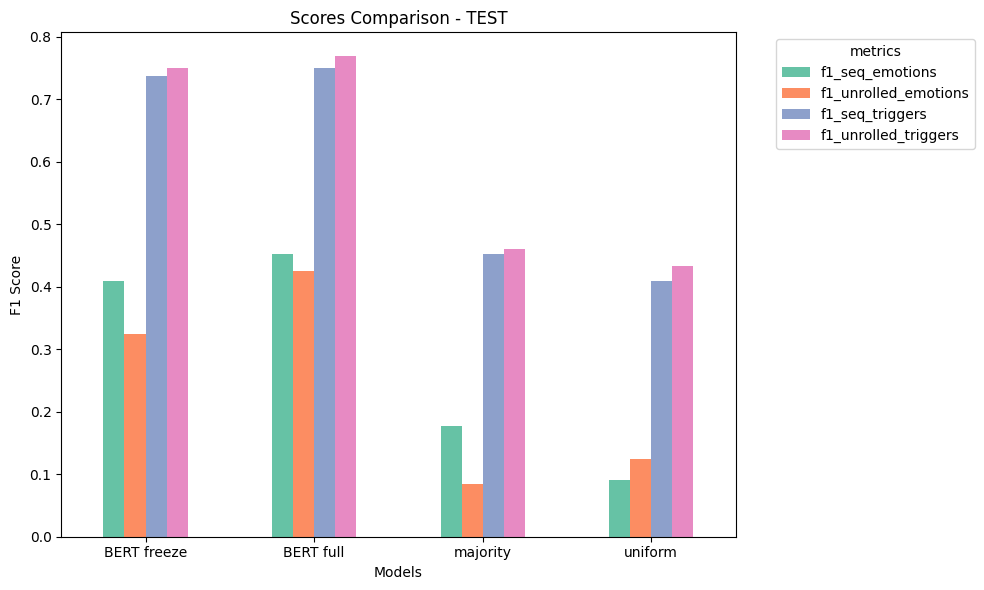

In [ ]:
get_comparison_plot(df_test, "TEST")

As might be expected, the BERT models outperform the Dummy Classifiers. Across all models the scores obtained in the classification of triggers is consistently higher than the one obtained in the classification of emotions, this is easily attributable to the fact that the binary classification is simpler and there is a higher probability of assigning the correct class.

Another important point to note is how the predictions of the validation and test set maintain almost the same ratios between the scores. This positive indication suggests that:  
- the training set effectively represents the validation and test set, allowing for a robust generalization of the data;
- the similarity between the validation and the test set ensures that the fine-tuning applied during model training is effective.

Furthermore the majority and BERT models exhibit superior performance when it comes to emotion detection at the dialogue level and triggers at global level. The uniform classifier displays the opposite behavior.

We are now interested in further investigating the predictions made by the BERT model as we already know the distributions of the outcomes predicted by the dummies.

### 7.2. Error analysis for the freezed BERT model

#### 7.2.1. **TRIGGERS**

In [ ]:
# Calculate the supports for the predicted triggers
total_triggers = len(list(chain.from_iterable(seeds_results_val_freeze[best_seed_freeze_bert_base]["tri_pred"])))

test_pred_supports_tri = sum(list(chain.from_iterable(seeds_results_test_freeze[best_seed_freeze_bert_base]["tri_pred"])))
test_pred_supports_tri = [(total_triggers - test_pred_supports_tri), test_pred_supports_tri]

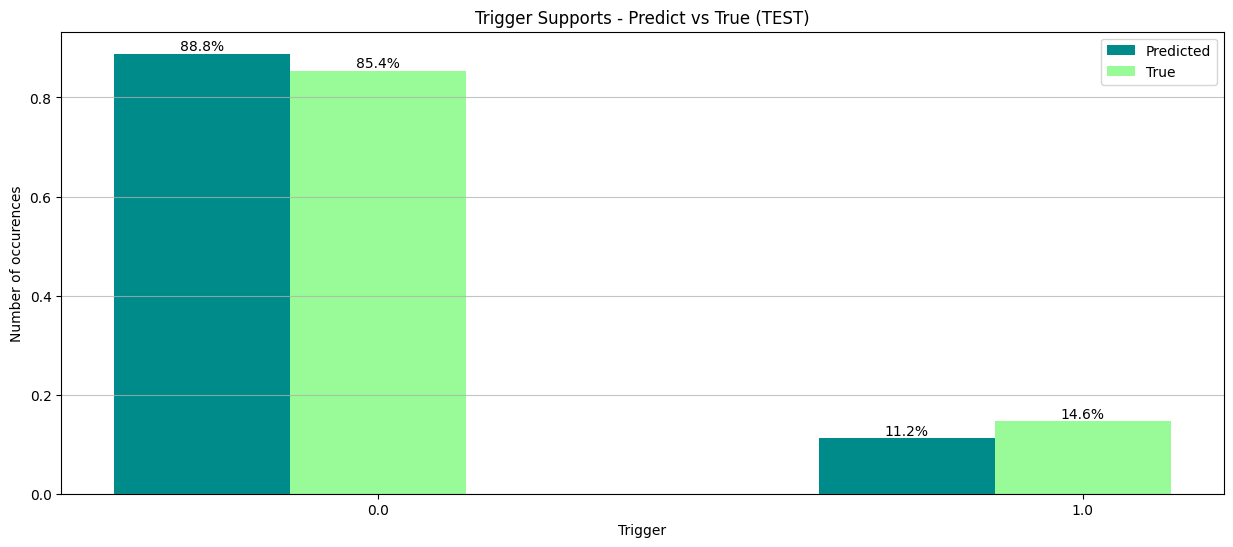

In [ ]:
# Plot the supports for the predicted triggers in the test set
get_support_plots("Trigger Supports - Predict vs True (TEST)", "Trigger", "Number of occurences", [test_pred_supports_tri, test_support_triggers], UNIQUE_TRIGGERS, ["Predicted", "True"])

In [ ]:
def get_wrong_triggers(pred, y_true, df):
  '''
    Function to identify false positives (FP) and false negatives (FN) in trigger predictions.
      :param pred (list): list of predicted triggers for each utterance in each dialogue.
      :param y_true (list): ground truth triggers for each utterance in each dialogue.

      :return dict: a dictionary containing the indices of false positives (FP) and false negatives (FN).
  '''
  wrong_utt_tri = {}
  fp = []
  fn = []
  for i, dia in enumerate(pred):
    for j, utt in enumerate(dia):
      if(utt != y_true[df.index[i]][j]): # if misclassied
        if(utt):
          fp.append([df.index[i],j]) # false positve
        else:
          fn.append([df.index[i],j]) # false negative

  wrong_utt_tri["FP"] = fp
  wrong_utt_tri["FN"] = fn

  return wrong_utt_tri

We will now examine instances of trigger's misclassifications, starting with False Negative and then moving to False Positive.



In [ ]:
def print_example(test_df, pred, y_true, n_examples, type_of_errors):
  """
      Function to print the first n_examples errors of False Positive and False Negative cases in trigger predictions.
  """
  mistaken_idx = get_wrong_triggers(pred, y_true, test_df)[type_of_errors]
  if(n_examples <= len(mistaken_idx)):
    for i in range(n_examples):
      idx_dia, idx_utt = mistaken_idx[i]
      print("\n DIALOGUE ", idx_dia)
      for j, utt in enumerate(test_df["utterances"][idx_dia]):
        if(test_df["triggers"][idx_dia][j]):
          print("",j,". TRIGGER - ", test_df["speakers"][idx_dia][j], ":", utt," (",UNIQUE_EMOTIONS[np.argmax(test_df["emotions"][idx_dia][j])],")")
        else:
          print("",j,". ", test_df["speakers"][idx_dia][j],":", utt," (",UNIQUE_EMOTIONS[np.argmax(test_df["emotions"][idx_dia][j])],")")
      if(type_of_errors == "FP"):
         print("! utterance", idx_utt ,"was classified as trigger but it is not")
      else:
         print("! utterance", idx_utt ,"is a trigger but was not recognized")
  else:
    print("the maximum number of example you can choose is ", len(mistaken_idx))


In [ ]:
# False Positive
def print_examples_FP(test_df, pred, y_true, n_examples):
  print_example(test_df, pred, y_true, n_examples, "FP")

# False Negative
def print_examples_FN(test_df, pred, y_true, n_examples):
  print_example(test_df, pred, y_true, n_examples, "FN")

In [ ]:
# False Negative examples
pred = seeds_results_test_freeze[best_seed_freeze_bert_base]["tri_pred"]
y_true = seeds_results_test_freeze[best_seed_freeze_bert_base]["tri_true"]
print_examples_FN(test_df, pred, y_true, 3)


 DIALOGUE  0
 0 .  Phoebe : It's Phoebe.  ( neutral )
 1 . TRIGGER -  Phoebe : Umm, well I sorta have some bad news, can I come in?  ( sadness )
! utterance 1 is a trigger but was not recognized

 DIALOGUE  1
 0 .  Monica : Okay, here's batch 22.  ( neutral )
 1 . TRIGGER -  Monica : Oh, maybe these'll taste a little like your grandmother's.  ( anger )
! utterance 1 is a trigger but was not recognized

 DIALOGUE  3
 0 .  Ross : I didn't even realise how late it was, until I noticed the 5 o'clock shadow on her head.  ( neutral )
 1 . TRIGGER -  Ross : Anyway, she didn't want to stay.  ( sadness )
! utterance 1 is a trigger but was not recognized


In [ ]:
# False Positive examples
print_examples_FP(test_df, pred, y_true, 3)


 DIALOGUE  5
 0 .  Joey : Hey, y'know what a really good rainy day game is?  ( neutral )
 1 .  Monica : What?!  ( neutral )
 2 . TRIGGER -  Joey : I mean naked game. Strip poker, we should totally play strip poker.  ( joy )
! utterance 1 was classified as trigger but it is not

 DIALOGUE  6
 0 .  Rachel : I'm so sorry, you guys. I didn't mean to bring you down.  ( sadness )
 1 .  Monica : No, you were right. I don't have a plan.  ( neutral )
 2 . TRIGGER -  Rachel : Thank God. Food.  ( joy )
! utterance 1 was classified as trigger but it is not

 DIALOGUE  8
 0 .  Monica : The waiter carried the breadsticks in his pants!  ( anger )
 1 .  Allesandro : Well, you said that we except the  ( neutral )
 2 .  Monica : All right, that I'll retract.  ( neutral )
! utterance 1 was classified as trigger but it is not


Manually inspecting the retrieved examples, it was possible to notice that:
the model tends to predict triggers in proximity to other triggers, often predicting the last utterance of the dialogue as a trigger.
Some of the False Negative errors are not proper mistakes, since sometimes the dataset is inconsistent with the definition of a trigger. For example it recognizes as trigger the last utterance of the dialogue, which can't be true (if it is not a self-trigger), since it can't cause an emotion flip for any of the following utterances. Sometimes also it doesn't set triigers equal true when an emotion flip occurs. This inconsistency is likely a result of dialogue truncation in the dataset.

#### 7.2.2. **EMOTIONS**

We proceed to compare the predicted results also for the emotions.

In [ ]:
# Get the results (predictions and ground truth) for the best seed
flatten_test_pred_emo = np.array(list(chain.from_iterable(seeds_results_test_freeze[best_seed_freeze_bert_base]["emo_pred"])))
flatten_test_true_emo = np.array(list(chain.from_iterable(seeds_results_test_freeze[best_seed_freeze_bert_base]["emo_true"])))

# Calculate the supports for the predicted emotions in the test set
emotions_pred_test, freq_pred_test = np.unique(flatten_test_pred_emo, return_counts=True)
test_pred_supports_emo = np.zeros(len(UNIQUE_EMOTIONS))
test_pred_supports_emo[emotions_pred_test]  = freq_pred_test

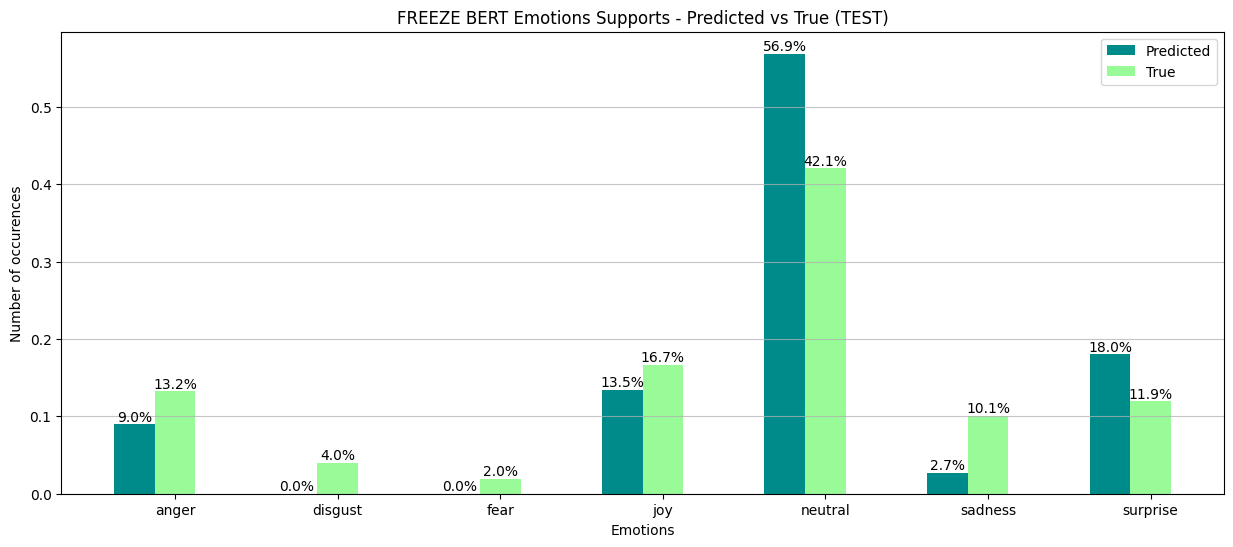

In [ ]:
# Plot the supports for the predicted emotions in the test set
get_support_plots("FREEZE BERT Emotions Supports - Predicted vs True (TEST)", "Emotions", "Number of occurences", [test_pred_supports_emo, test_support_emotions], UNIQUE_EMOTIONS, ["Predicted","True"])

Observing the graphs is possible to notice that the BERT model predominantly classifies emotions as 'neutral' and never assigns them the labels 'disgust' or 'fear'.
Thanks to the data exploration done at the beginning of this notebook the reason is easy to guess: the classifications of our BERT model are strongly correlated with the class support in the training set.

We are now interested in examining major details about the misclassifications of each emotion in the test set.

In [ ]:
def get_err_stats(flatten_pred, flatten_true, support):
  '''
    Function to calculate error statistics for emotion predictions.
    : param flatten_pred: the predicted emotions.
    : param flatten_true: the true emotions.
    : param support: the support of the emotions.

    returns a tuple containing two dictionaries.
        - The first dictionary (emotion_class_freq) represents the frequency of predicted emotions.
        - The second dictionary (errors_perc) represents the percentage of errors for each emotion.
  '''
  emotion_class_freq = {key: [] for key in range(len(UNIQUE_EMOTIONS))}
  errors_perc = {key: [] for key in range(len(UNIQUE_EMOTIONS))}

  for i, emo in enumerate(flatten_true):
          emotion_class_freq[emo].append(flatten_pred[i])

  for emo in emotion_class_freq.keys():
      emotions_pred, freq_pred = np.unique( emotion_class_freq[emo], return_counts=True)
      count_per_emo  = np.zeros(len(UNIQUE_EMOTIONS))
      count_per_emo[emotions_pred] = freq_pred
      emotion_class_freq[emo] = count_per_emo

  for emo in emotion_class_freq.keys():
      errors_per_emo = [count for i, count in enumerate(emotion_class_freq[emo]) if i != emo]
      errors_perc[emo] = (sum(errors_per_emo)/support[emo])*100
  return emotion_class_freq, errors_perc

In [ ]:
def get_errors_perc_df(errors_perc):
  """
    Convert error_perc to DataFrame.
  """
  df_errors_perc = pd.DataFrame(errors_perc.values())
  df_errors_perc.index = UNIQUE_EMOTIONS
  df_errors_perc = df_errors_perc.rename(columns={0: 'percentage error per tag'})
  df_errors_perc.sort_values(by='percentage error per tag', ascending=False)
  return df_errors_perc

In [ ]:
# Calculate precision and recall for the emotions
precision_emo = precision_score(flatten_test_true_emo, flatten_test_pred_emo, average=None, zero_division=0)
recall_emo = recall_score(flatten_test_true_emo, flatten_test_pred_emo, average=None)

precision_recall_emo_freeze = pd.DataFrame(np.array([precision_emo, recall_emo]).T, columns=["precision", "recall"], index=UNIQUE_EMOTIONS)
precision_recall_emo_freeze

,precision,recall
anger,0.413580,0.280335
disgust,0.000000,0.000000
fear,0.000000,0.000000
joy,0.494867,0.399668
neutral,0.624027,0.842970
sadness,0.693878,0.186301
surprise,0.425499,0.641204


In [ ]:
# Get the error statistics for the emotions in the test set
emotion_class_freq, errors_perc = get_err_stats(flatten_test_pred_emo, flatten_test_true_emo, test_support_emotions)
df_errors_perc = get_errors_perc_df(errors_perc)
df_errors_perc

,percentage error per tag
anger,71.966527
disgust,100.000000
fear,100.000000
joy,60.033167
neutral,15.703022
sadness,81.369863
surprise,35.879630


As highlighted by the graph, there is a consistent difference between the errors of each tag. Observing the precision and recall is possible to notice that in classes as 'neutral' and 'surprise' the recall is higher than the precision, this means that the model tends to classify a higher number of examples as positive, but some of them may be false positives.   

In [ ]:
def get_errors_perc_per_emo(emotion_class_freq):
  """
    For each emotion, it returns the percentage of times it is classified as another emotion.
  """
  errors_perc_per_emo = {key: [] for key in range(len(UNIQUE_EMOTIONS))}
  for i in emotion_class_freq.keys():
      print()
      for j in emotion_class_freq.keys():
          perc = (emotion_class_freq[i][j] / sum(emotion_class_freq[i])) * 100
          errors_perc_per_emo[i].append(perc)
  return errors_perc_per_emo

In [ ]:
# Print the percentage of times each emotion is classified as another emotion
errors_perc_per_emo = {key: [] for key in range(len(UNIQUE_EMOTIONS))}
for i in emotion_class_freq.keys():
    for j in emotion_class_freq.keys():
        perc = (emotion_class_freq[i][j] / sum(emotion_class_freq[i])) * 100
        errors_perc_per_emo[i].append(perc)

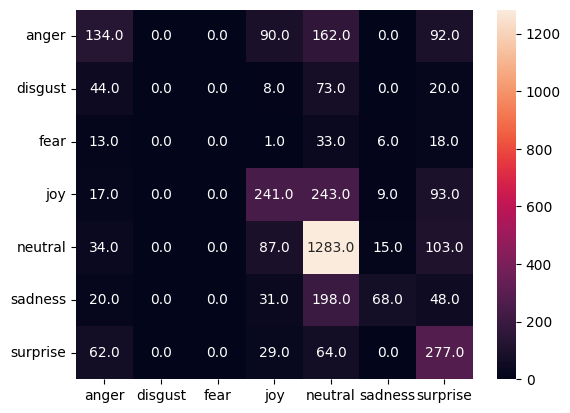

In [ ]:
# Create a Seaborn heatmap displaying emotion class frequencies as a matrix with annotations
sns.heatmap(list(emotion_class_freq.values()), annot = True, fmt='', xticklabels=UNIQUE_EMOTIONS, yticklabels=UNIQUE_EMOTIONS);

In [ ]:
df_freq_per = pd.DataFrame(get_errors_perc_per_emo(emotion_class_freq).values(),index = UNIQUE_EMOTIONS, columns = UNIQUE_EMOTIONS).round(2)
print("Confusion Matrix with Error Percentages")
display(df_freq_per)








Confusion Matrix with Error Percentages


,anger,disgust,fear,joy,neutral,sadness,surprise
anger,28.03,0.0,0.0,18.83,33.89,0.00,19.25
disgust,30.34,0.0,0.0,5.52,50.34,0.00,13.79
fear,18.31,0.0,0.0,1.41,46.48,8.45,25.35
joy,2.82,0.0,0.0,39.97,40.30,1.49,15.42
neutral,2.23,0.0,0.0,5.72,84.30,0.99,6.77
sadness,5.48,0.0,0.0,8.49,54.25,18.63,13.15
surprise,14.35,0.0,0.0,6.71,14.81,0.00,64.12


It's interesting to notice that 'surprise' is the class that, considering the percentages, is classified as neutral improperly less frequently than the others. Even though it does not have the highest support in the training set, the model manages to learn it quite well.

In [ ]:
def get_id_wrong_emotions(y_true, pred):
    '''
      Function to identify misclasified emotions.
      : param y_true: ground truth emotions for each utterance in each dialogue.
      : param pred: list of predicted emotions for each utterance in each dialogue.

      return: a list containing the indices of misclasification
    '''
    wrong_class = []
    for i, dia in enumerate(pred):
        for j, utt in enumerate(dia):
          if(utt != y_true[i][j]):
             wrong_class.append([i,j])
    return wrong_class

In [ ]:
def print_misclassified_utterances(wrong_predictions_list, n_examples, df, seeds_results, best_seed):
  '''
    Function to print misclassified utterances ids.
    : param wrong_predictions_list: list of misclassified utterances.
    : param n_examples: number of examples to print.
    : param df: the dataframe.
    : param seeds_results: the results for the different seeds.
    : param best_seed: the best seed.
  '''
  if(n_examples <= len(wrong_predictions_list)):
    for i in range(n_examples):
      dia_idx = wrong_predictions_list[i][0]
      utt_idx = wrong_predictions_list[i][1]
      print("\nDIALOGUE ", dia_idx)
      print(df["utterances"][dia_idx])

      print("MISCLASSIFIED UTTERANCE")
      print(test_df["utterances"][dia_idx][utt_idx])
      print("predicted as", UNIQUE_EMOTIONS[seeds_results[best_seed]["emo_pred"][dia_idx][utt_idx]].upper(),"instead of", UNIQUE_EMOTIONS[seeds_results[best_seed]["emo_true"][dia_idx][utt_idx]].upper())
  else:
    print("the maximum number of example you can choose is ", len(wrong_predictions_list))

In [ ]:
# Print misclassified utterances
wrong_predictions_list = get_id_wrong_emotions(seeds_results_test_freeze[best_seed_freeze_bert_base]["emo_true"], seeds_results_test_freeze[best_seed_freeze_bert_base]["emo_pred"])
print_misclassified_utterances(wrong_predictions_list, 5, test_df, seeds_results_test_freeze, best_seed_freeze_bert_base)


DIALOGUE  0
["It's Phoebe.", 'Umm, well I sorta have some bad news, can I come in?']
MISCLASSIFIED UTTERANCE
Umm, well I sorta have some bad news, can I come in?
predicted as NEUTRAL instead of SADNESS

DIALOGUE  1
["Okay, here's batch 22.", "Oh, maybe these'll taste a little like your grandmother's."]
MISCLASSIFIED UTTERANCE
Oh, maybe these'll taste a little like your grandmother's.
predicted as NEUTRAL instead of ANGER

DIALOGUE  2
['Yeah!', "Anyway, I-I still think we should try to patch things up, y'know?"]
MISCLASSIFIED UTTERANCE
Yeah!
predicted as JOY instead of ANGER

DIALOGUE  3
["I didn't even realise how late it was, until I noticed the 5 o'clock shadow on her head.", "Anyway, she didn't want to stay."]
MISCLASSIFIED UTTERANCE
Anyway, she didn't want to stay.
predicted as NEUTRAL instead of SADNESS

DIALOGUE  4
['Okay, then what happened?', "Ohh. Uh-huh. Uh-huh.  You'll get your turn!"]
MISCLASSIFIED UTTERANCE
Ohh. Uh-huh. Uh-huh.  You'll get your turn!
predicted as JOY inst

### 7.3. Error analysis for the full BERT model

In the following sections, we will analyze the performance of Full BERT.

In [ ]:
def improvement_percent(old_f1, new_f1):
  '''
    Function to calculate the improvement percentage between two f1 scores.
  '''
  improvement_percent = ((new_f1 - old_f1) / old_f1) * 100
  return improvement_percent

In [ ]:
print("Using full BERT there is an improvement in the obtained scores of:")

print(f"f1_seq_emotions {improvement_percent( scores_test_freeze['f1_seq_emotions'][best_seed_freeze_bert_base] ,scores_test_full['f1_seq_emotions'][best_seed_full]):.2f} %")
print(f"f1_unrolled_emotions {improvement_percent( scores_test_freeze['f1_unrolled_emotions'][best_seed_freeze_bert_base] ,scores_test_full['f1_unrolled_emotions'][best_seed_full]):.2f} %")
print(f"f1_seq_triggers {improvement_percent( scores_test_freeze['f1_seq_triggers'][best_seed_freeze_bert_base] ,scores_test_full['f1_seq_triggers'][best_seed_full]):.2f} %")
print(f"f1_unrolled_triggers {improvement_percent( scores_test_freeze['f1_unrolled_triggers'][best_seed_freeze_bert_base] ,scores_test_full['f1_unrolled_triggers'][best_seed_full]):.2f} %")

Using full BERT there is an improvement in the obtained scores of:
f1_seq_emotions 12.91 %
f1_unrolled_emotions 35.45 %
f1_seq_triggers 2.26 %
f1_unrolled_triggers 2.98 %


The use of full BERT allows for the maximization of BERT's adaptive capacity, which is positively reflected in the scores obtained.

#### 7.3.1. **TRIGGERS**

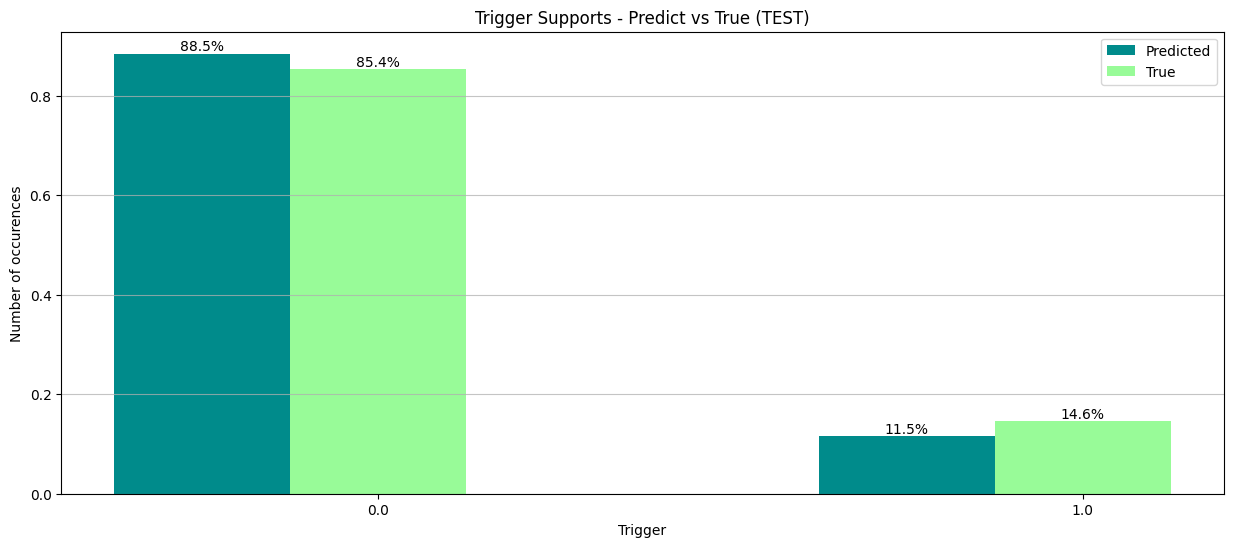

In [ ]:
# Calculate and plot the supports for the predicted triggers in the test set
full_test_pred_supports_tri = sum(list(chain.from_iterable(seeds_results_test_full[best_seed_full]["tri_pred"])))
full_test_pred_supports_tri = [(total_triggers - full_test_pred_supports_tri), full_test_pred_supports_tri]
get_support_plots("Trigger Supports - Predict vs True (TEST)", "Trigger", "Number of occurences", [full_test_pred_supports_tri, test_support_triggers], UNIQUE_TRIGGERS, ["Predicted", "True"])

Compared to the predictions from the freezed BERT model, there is no particular improvement in the trigger predictions. The previous considerations regarding the examples remain the same.

In [ ]:
# False negative examples
pred = seeds_results_test_full[best_seed_freeze_bert_base]["tri_pred"]
y_true = seeds_results_test_full[best_seed_freeze_bert_base]["tri_true"]

print("False Negative")
print_examples_FN(test_df, pred, y_true, 30)

False Negative

 DIALOGUE  1
 0 .  Monica : Okay, here's batch 22.  ( neutral )
 1 . TRIGGER -  Monica : Oh, maybe these'll taste a little like your grandmother's.  ( anger )
! utterance 1 is a trigger but was not recognized

 DIALOGUE  3
 0 .  Ross : I didn't even realise how late it was, until I noticed the 5 o'clock shadow on her head.  ( neutral )
 1 . TRIGGER -  Ross : Anyway, she didn't want to stay.  ( sadness )
! utterance 1 is a trigger but was not recognized

 DIALOGUE  4
 0 .  Phoebe : Okay, then what happened?  ( neutral )
 1 . TRIGGER -  Phoebe : Ohh. Uh-huh. Uh-huh.  You'll get your turn!  ( anger )
! utterance 1 is a trigger but was not recognized

 DIALOGUE  5
 0 .  Joey : Hey, y'know what a really good rainy day game is?  ( neutral )
 1 .  Monica : What?!  ( neutral )
 2 . TRIGGER -  Joey : I mean naked game. Strip poker, we should totally play strip poker.  ( joy )
! utterance 2 is a trigger but was not recognized

 DIALOGUE  6
 0 .  Rachel : I'm so sorry, you guys. I

In [ ]:
# False positive examples
print("False Positive")
print_examples_FP(test_df, pred, y_true, 5)

False Positive

 DIALOGUE  3
 0 .  Ross : I didn't even realise how late it was, until I noticed the 5 o'clock shadow on her head.  ( neutral )
 1 . TRIGGER -  Ross : Anyway, she didn't want to stay.  ( sadness )
! utterance 0 was classified as trigger but it is not

 DIALOGUE  5
 0 .  Joey : Hey, y'know what a really good rainy day game is?  ( neutral )
 1 .  Monica : What?!  ( neutral )
 2 . TRIGGER -  Joey : I mean naked game. Strip poker, we should totally play strip poker.  ( joy )
! utterance 1 was classified as trigger but it is not

 DIALOGUE  6
 0 .  Rachel : I'm so sorry, you guys. I didn't mean to bring you down.  ( sadness )
 1 .  Monica : No, you were right. I don't have a plan.  ( neutral )
 2 . TRIGGER -  Rachel : Thank God. Food.  ( joy )
! utterance 1 was classified as trigger but it is not

 DIALOGUE  8
 0 .  Monica : The waiter carried the breadsticks in his pants!  ( anger )
 1 .  Allesandro : Well, you said that we except the  ( neutral )
 2 .  Monica : All right, 

#### 7.3.2. **EMOTIONS**

We proceed to compare the predicted results also for the emotions.

In [ ]:
# Get the results (predictions and ground truth) for the best seed
full_flatten_test_pred_emo = np.array(list(chain.from_iterable(seeds_results_test_full[best_seed_full]["emo_pred"])))
full_flatten_test_true_emo = np.array(list(chain.from_iterable(seeds_results_test_full[best_seed_full]["emo_true"])))

# Calculate the supports for the predicted emotions in the test set
emotions_pred_test, freq_pred = np.unique(full_flatten_test_pred_emo, return_counts=True)
full_test_pred_supports_emo = np.zeros(len(UNIQUE_EMOTIONS))
full_test_pred_supports_emo[emotions_pred_test] = freq_pred

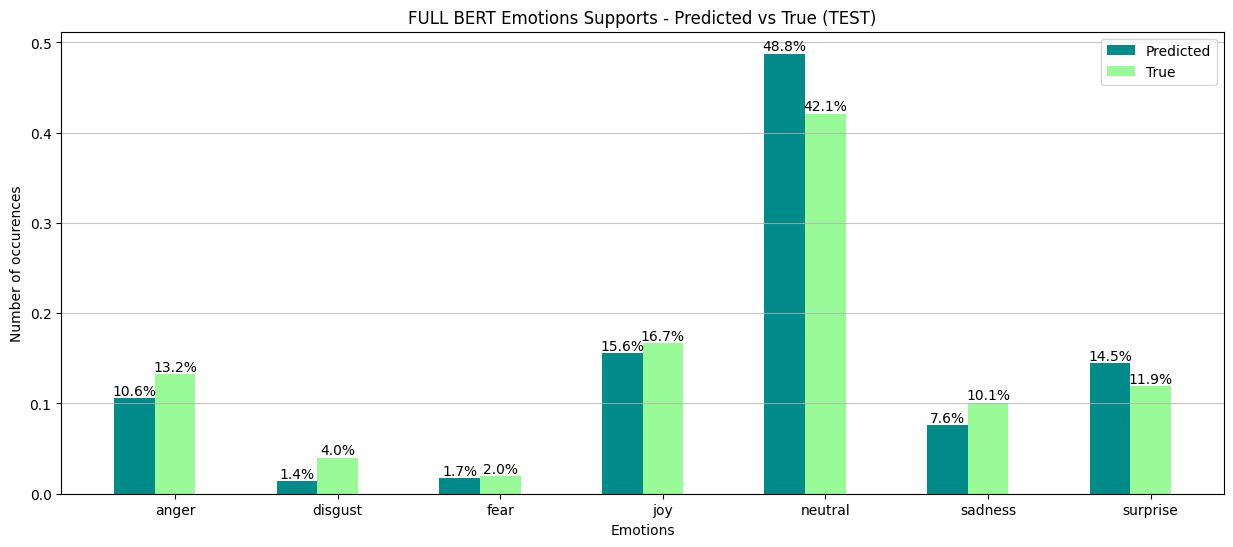

In [ ]:
# Plot the supports for the predicted emotions in the test set
get_support_plots("FULL BERT Emotions Supports - Predicted vs True (TEST)", "Emotions", "Number of occurences", [full_test_pred_supports_emo, test_support_emotions], UNIQUE_EMOTIONS, ["Predicted", "True"])

The use of full BERT has led to a modification of the prediction distribution, making it more likely to the expected outcomes. The increased sensitivity towards less-represented classes reduced the number of emotion classified as 'neutral' allowing predictions for all the classes, including 'fear' and 'disgust'.

In [ ]:
# Calculate precision and recall for the emotions
precision_emo = precision_score(full_flatten_test_true_emo, full_flatten_test_pred_emo, average=None, zero_division=0)
recall_emo = recall_score(full_flatten_test_true_emo, full_flatten_test_pred_emo, average=None)

precision_recall_emo_full = pd.DataFrame(np.array([precision_emo, recall_emo]).T, columns=["precision", "recall"], index=UNIQUE_EMOTIONS)
precision_recall_emo_full

,precision,recall
anger,0.475196,0.380753
disgust,0.469388,0.158621
fear,0.180328,0.154930
joy,0.571936,0.533997
neutral,0.688032,0.796978
sadness,0.485401,0.364384
surprise,0.529637,0.641204


In [ ]:
# Get the error statistics for the emotions in the test set
full_emotion_class_freq, full_errors_perc = get_err_stats(full_flatten_test_pred_emo, full_flatten_test_true_emo, test_support_emotions)
full_df_errors_perc = get_errors_perc_df(full_errors_perc)
full_df_errors_perc

,percentage error per tag
anger,61.924686
disgust,84.137931
fear,84.507042
joy,46.600332
neutral,20.302234
sadness,63.561644
surprise,35.879630


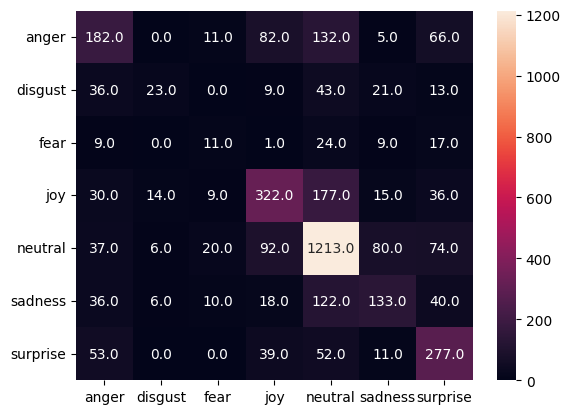

In [ ]:
# Heatmap with the classification distribution for each emotion
sns.heatmap(list(full_emotion_class_freq.values()), annot = True, fmt='', xticklabels=UNIQUE_EMOTIONS, yticklabels=UNIQUE_EMOTIONS);

The full BERT model distributes the errors more uniformly among all the classes. The accuracy in the 'neutral' class has decreased, mainly because the model is no longer predicting it as frequently as before, contributing to improve accuracy in other classes.

In [ ]:
full_df_freq_per = pd.DataFrame(get_errors_perc_per_emo(full_emotion_class_freq).values(),index = UNIQUE_EMOTIONS, columns = UNIQUE_EMOTIONS).round(2)
print("Confusion Matrix with Error Percentages")
display(full_df_freq_per)








Confusion Matrix with Error Percentages


,anger,disgust,fear,joy,neutral,sadness,surprise
anger,38.08,0.00,2.30,17.15,27.62,1.05,13.81
disgust,24.83,15.86,0.00,6.21,29.66,14.48,8.97
fear,12.68,0.00,15.49,1.41,33.80,12.68,23.94
joy,4.98,2.32,1.49,53.40,29.35,2.49,5.97
neutral,2.43,0.39,1.31,6.04,79.70,5.26,4.86
sadness,9.86,1.64,2.74,4.93,33.42,36.44,10.96
surprise,12.27,0.00,0.00,9.03,12.04,2.55,64.12


In [ ]:
# Print the first N misclassified utterances
wrong_predictions_list = get_id_wrong_emotions(seeds_results_test_full[best_seed_full]["emo_true"], seeds_results_test_full[best_seed_full]["emo_pred"])
print_misclassified_utterances(wrong_predictions_list, 5, test_df, seeds_results_test_full, best_seed_full)


DIALOGUE  0
["It's Phoebe.", 'Umm, well I sorta have some bad news, can I come in?']
MISCLASSIFIED UTTERANCE
Umm, well I sorta have some bad news, can I come in?
predicted as NEUTRAL instead of SADNESS

DIALOGUE  1
["Okay, here's batch 22.", "Oh, maybe these'll taste a little like your grandmother's."]
MISCLASSIFIED UTTERANCE
Oh, maybe these'll taste a little like your grandmother's.
predicted as NEUTRAL instead of ANGER

DIALOGUE  2
['Yeah!', "Anyway, I-I still think we should try to patch things up, y'know?"]
MISCLASSIFIED UTTERANCE
Yeah!
predicted as JOY instead of ANGER

DIALOGUE  3
["I didn't even realise how late it was, until I noticed the 5 o'clock shadow on her head.", "Anyway, she didn't want to stay."]
MISCLASSIFIED UTTERANCE
I didn't even realise how late it was, until I noticed the 5 o'clock shadow on her head.
predicted as SADNESS instead of NEUTRAL

DIALOGUE  4
['Okay, then what happened?', "Ohh. Uh-huh. Uh-huh.  You'll get your turn!"]
MISCLASSIFIED UTTERANCE
Ohh. Uh-h

## 8. Conclusions

Despite the significant imbalance among triggers in the dataset, the results are notably satisfactory. The binary aspect of trigger identification likely plays a role in diminishing the adverse effects of this imbalance. However, addressing class imbalance in emotions proves more challenging, with complete BERT fine-tuning making a notable difference.